# Multimodal Gesture Recognition: From EDA to Production Models

**Project:** Kaggle CMI - Detect Behavior with Sensor Data  
**Author:** Eldad & Nadav  
**Date:** January 2026

---

## 📋 Challange Overview

### The Challenge

[Kaggle CMI - Detect Behavior with Sensor Data](https://www.kaggle.com/competitions/cmi-detect-behavior-with-sensor-data)  

Using movement, temperature, and proximity sensor data to differentiate between **body-focused repetitive behaviors (BFRBs)** — like hair pulling and skin picking — from everyday non-BFRB gestures like adjusting glasses or waving

**Goal**: Develop a predictive model that distinguishes BFRB-like from non-BFRB-like activity using data from the **Helios** wrist-worn device.

### Why This Matters

BFRBs such as hair pulling (trichotillomania), skin picking (excoriation), and nail biting are self-directed repetitive behaviors commonly seen in:
- Anxiety disorders
- Obsessive-compulsive disorder (OCD)
- Other mental health challenges

Accurate detection can improve treatment tools and support mental health interventions.

**References**:
- [What Is Excoriation, or Skin-Picking?](https://childmind.org/article/excoriation-or-skin-picking/)
- [What is Trichotillomania?](https://childmind.org/article/what-is-trichotillomania/)

---

### The Helios Device

The Child Mind Institute developed a wrist-worn sensor device with **three sensor types**:

| Sensor Type | Count | Measurement |
|------------|-------|-------------|
| **IMU** (BNO080/BNO085) | 1x | Accelerometer, gyroscope, magnetometer (orientation & motion) |
| **Thermopile** (MLX90632) | 5x | Non-contact temperature (infrared radiation, °C) |
| **Time-of-Flight** (VL53L7CX) | 5x | Distance measurement (8×8 pixel grid per sensor = 320 pixels total) |


| | |
|---|---|
| ![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F16459904%2F0ff03ac3f2c2d2bf9e0eafc0135b52c2%2FScreenshot%202025-08-11%20at%203.59.48PM.png?generation=1754921390651163&alt=media) | ![](https://www.kaggle.com/competitions/102335/images/header) |

---

### Data Collection Protocol

Participants performed **18 unique gestures** (8 BFRB-like, 10 non-BFRB-like) while wearing Helios on their **dominant wrist**. Each sequence follows a 3-phase structure:

1. **Transition** → Move hand from rest to target location
2. **Pause** → Short pause (no action)
3. **Gesture** → Execute the target gesture

**Body Positions**: Sitting, sitting leaning forward, lying on back, lying on side

---

### Gesture Categories

#### BFRB-Like Gestures (8 Target Behaviors)

* Above ear - Pull hair
* Forehead - Pull hairline
* Forehead - Scratch
* Eyebrow - Pull hair
* Eyelash - Pull hair
* Neck - Pinch skin
* Neck - Scratch
* Cheek - Pinch skin

#### Non-BFRB-Like Gestures (10 Everyday Behaviors)

* Drink from bottle/cup
* Glasses on/off
* Pull air toward your face
* Pinch knee/leg skin
* Scratch knee/leg skin
* Write name on leg
* Text on phone
* Feel around in tray
* Write name in air
* Wave hello

---

### Dataset Structure

**Training Data**: `train.csv`
- **574,945 frames** organized into **8,151 sequences**
- Each sequence = Transition + Pause + Gesture phases

**Key Columns**:
- `sequence_id`: Unique sequence identifier
- `sequence_counter`: Frame number within sequence
- `subject`: Participant ID
- `gesture`: Target label (18 gesture types)
- `orientation`: Body position during recording
- `phase`: Transition | Pause | Gesture
- `acc_[x/y/z]`: Linear acceleration (m/s²)
- `rot_[w/x/y/z]`: Quaternion orientation (4D)
- `thm_[1-5]`: Temperature from 5 thermopile sensors (°C)
- `tof_[1-5]_v[0-63]`: Distance from 5 ToF sensors (320 pixels, -1 = no response)

**Demographics**: `train_demographics.csv`
- Subject characteristics: age, sex, handedness, height, arm measurements

**Test Data**: Served via **evaluation API** (one sequence at a time)
- Expected **~3,500 sequences**
- 50% IMU-only, 50% full sensor

---

### Real-World Impact

Your solutions will:
1. **Inform sensor selection** for next-generation BFRB detection devices
2. **Quantify added value** of thermopile/ToF sensors vs IMU alone
3. **Guide design decisions** balancing accuracy vs cost/complexity
4. **Improve treatment tools** for mental health conditions involving BFRBs

---

## Table of Contents

1. [Setup & Data Loading](#1.-Setup-&-Data-Loading)
2. [Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
   - 2.1 [Time-of-Flight Sensors](#2.1-Time-of-Flight-Sensors)
   - 2.2 [Inertial Measurement Unit (IMU) Analysis](#2.2-Inertial-Measurement-Unit-%28IMU%29-Analysis)
   - 2.3 [Thermal Sensor Analysis](#2.3-Thermal-Sensor-Analysis)
3. [Supervised Learning & Model Development](#3.-Supervised-Learning-&-Model-Development)
   - [Challenge Overview](#Challenge-Overview)
   - [Identify Sequences with Corrupted IMU Data (Zero-Norm Quaternions)](#Identify-Sequences-with-Corrupted-IMU-Data-%28Zero-Norm-Quaternions%29)
4. [Summary](#Summary:)
5. [Future Directions](#Future-Directions)
6. [Final Project Goals](#Final-Project-Goals)

---

# 1. Setup & Data Loading

We begin by importing necessary libraries and loading the training dataset. The data comes from wearable sensors mounted on a wrist device, capturing multimodal signals during gesture performance.

In [1]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from scipy.spatial.transform import Rotation as R
from scipy.integrate import cumulative_trapezoid
import plotly.graph_objects as go
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load training data
try:
    path = kagglehub.competition_download('cmi-detect-behavior-with-sensor-data')
    train_df = pd.read_csv(os.path.join(path, 'train.csv'))
except:
    kagglehub.login()
    raise Exception("Rerun the notebook after sucessful login")

print(f"📊 Dataset loaded successfully!")
print(f"   - Total frames: {train_df.shape[0]:,}")
print(f"   - Total features: {train_df.shape[1]}")
print(f"   - Unique sequences: {train_df['sequence_id'].nunique():,}")
print(f"   - Unique subjects: {train_df['subject'].nunique()}")
print(f"   - Gesture classes: {train_df['gesture'].nunique()}")

# Display first few rows
train_df.head()

📊 Dataset loaded successfully!
   - Total frames: 574,945
   - Total features: 341
   - Unique sequences: 8,151
   - Unique subjects: 81
   - Gesture classes: 18


row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000007_000000        Target  SEQ_000007                 0  SUBJ_059520   
1  SEQ_000007_000001        Target  SEQ_000007                 1  SUBJ_059520   
2  SEQ_000007_000002        Target  SEQ_000007                 2  SUBJ_059520   
3  SEQ_000007_000003        Target  SEQ_000007                 3  SUBJ_059520   
4  SEQ_000007_000004        Target  SEQ_000007                 4  SUBJ_059520   

                       orientation                                   behavior  \
0  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
1  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
2  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
3  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
4  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   

        phase             gesture     acc_x  ...  tof_5_v54  tof_5_v55  \
0  Transition  Cheek - pinch skin  6.683594  ...       -1.0       -1.0   
1  Transition  Cheek - pinch skin  6.949219  ...       -1.0       -1.0   
2  Transition  Cheek - pinch skin  5.722656  ...       -1.0       -1.0   
3  Transition  Cheek - pinch skin  6.601562  ...       -1.0       -1.0   
4  Transition  Cheek - pinch skin  5.566406  ...       -1.0       -1.0   

   tof_5_v56  tof_5_v57  tof_5_v58  tof_5_v59  tof_5_v60  tof_5_v61  \
0       -1.0       -1.0       -1.0       -1.0       -1.0       -1.0   
1       -1.0       -1.0       -1.0       -1.0       -1.0       -1.0   
2      112.0      119.0       -1.0       -1.0       -1.0       -1.0   
3      101.0      111.0       -1.0       -1.0       -1.0       -1.0   
4      101.0      109.0      125.0       -1.0       -1.0       -1.0   

   tof_5_v62  tof_5_v63  
0       -1.0       -1.0  
1       -1.0       -1.0  
2       -1.0       -1.0  
3       -1.0       -1.0  
4       -1.0       -1.0  

[5 rows x 341 columns]

### Data Structure Explanation

The dataset contains **574,945 frames** representing time-series sensor readings during gesture performance. Key observations:

- **Sequences:** 8,151 gesture sequences performed by 81 subjects
- **Temporal Structure:** Each sequence contains variable-length frames (29-700 frames)
- **Sensor Features:** 341 columns including:
  - **ToF:** 320 features (5 sensors × 64 pixels)
  - **IMU:** 3 accelerometer + 4 rotation features  
  - **Thermal:** 5 temperature sensors
  - **Metadata:** Subject ID, sequence counter, orientation, etc.

**Challenge:** The test set is said to have 50% of sequences with ToF/thermal sensors **missing**, requiring robust IMU-based models.

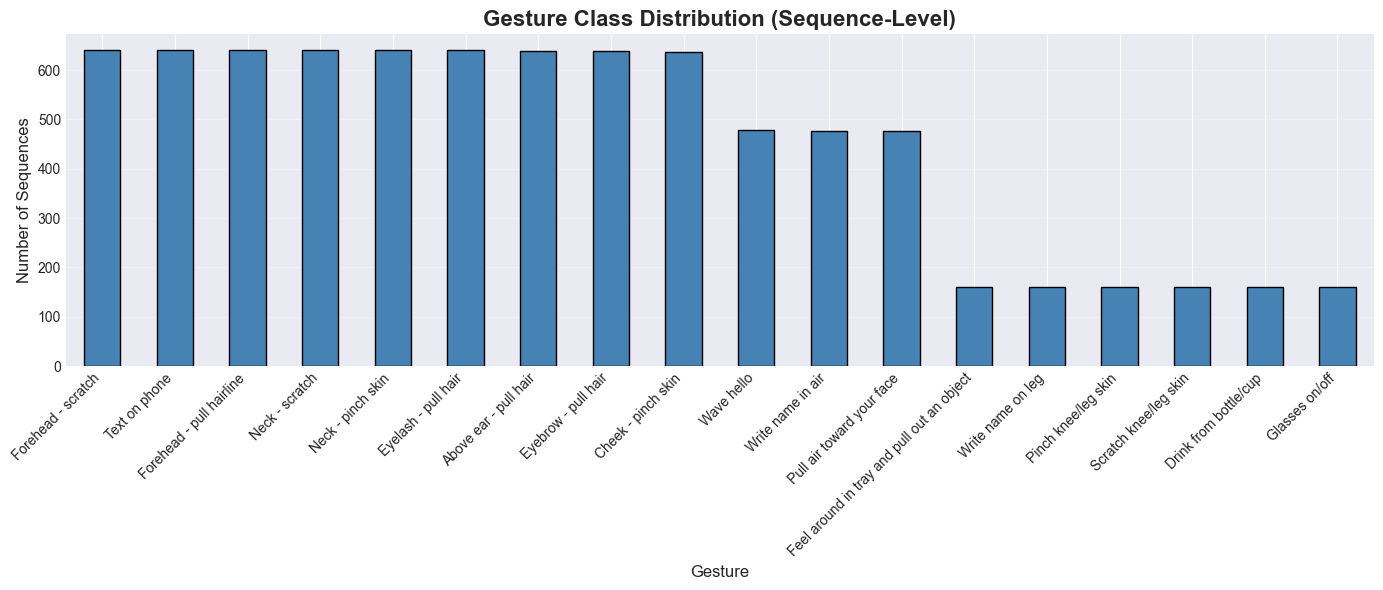


📊 Class Imbalance Analysis:
   - Most common gesture: Forehead - scratch (640 sequences)
   - Least common gesture: Glasses on/off (161 sequences)
   - Imbalance ratio: 4:1


In [3]:
# Examine gesture class distribution
gesture_counts = train_df.groupby('sequence_id')['gesture'].first().value_counts().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
gesture_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Gesture Class Distribution (Sequence-Level)', fontsize=16, fontweight='bold')
plt.xlabel('Gesture', fontsize=12)
plt.ylabel('Number of Sequences', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Class Imbalance Analysis:")
print(f"   - Most common gesture: {gesture_counts.index[0]} ({gesture_counts.iloc[0]} sequences)")
print(f"   - Least common gesture: {gesture_counts.index[-1]} ({gesture_counts.iloc[-1]} sequences)")
print(f"   - Imbalance ratio: {gesture_counts.iloc[0] / gesture_counts.iloc[-1]:.0f}:1")

### Class Imbalance Insight

The bar chart reveals significant **class imbalance** (approximately 4:1 ratio between most and least common gestures). This imbalance requires:

1. **Stratified splitting** to maintain class proportions in train/validation sets
2. **Class-balanced training** using sample weights
3. **Careful evaluation** using macro-averaged metrics (not just accuracy)

**BFRB Gestures** (target behaviors): 8 out of 18 gestures involve body-focused repetitive behaviors like hair pulling, skin pinching, and scratching.

---

# 2. Exploratory Data Analysis

We now perform comprehensive analysis of each sensor modality to understand their characteristics and discriminative power for gesture recognition.

## 2.1 Time-of-Flight Sensors

ToF sensors measure distance using infrared light, providing spatial information about hand position. The device has **5 sensors arranged in a cross pattern**, each with an 8×8 pixel grid (320 total features).

📡 Time-of-Flight Sensors Analysis
   - Total ToF features: 320
   - Sensors: 5 (each with 8×8 = 64 pixels)
   - Measurement range: 0-249 mm


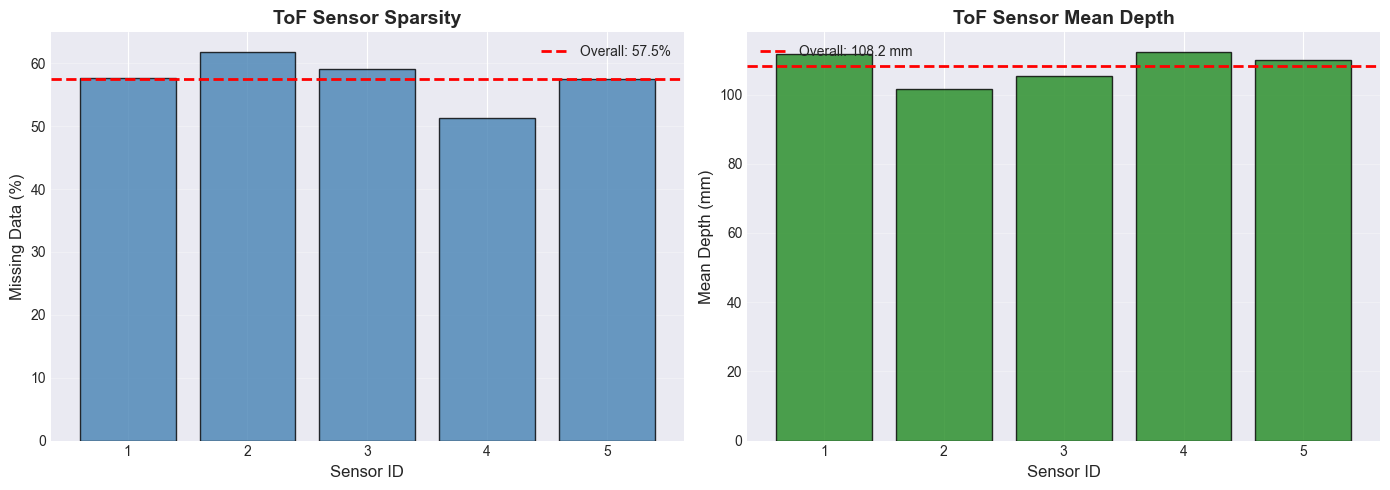


📊 Key Statistics:
   - Overall sparsity: 57.5% (of data is missing)
   - Overall mean depth: 108.21 mm


In [4]:
# Extract ToF columns
tof_cols = [col for col in train_df.columns if col.startswith('tof_')]

print(f"📡 Time-of-Flight Sensors Analysis")
print(f"   - Total ToF features: {len(tof_cols)}")
print(f"   - Sensors: 5 (each with 8×8 = 64 pixels)")
print(f"   - Measurement range: 0-249 mm")

# Analyze sparsity (missing values marked as -1)
sparsity_per_sensor = {}
mean_depth_per_sensor = {}

for sensor_id in range(1, 6):
    sensor_cols = [col for col in tof_cols if col.startswith(f'tof_{sensor_id}_')]
    sensor_data = train_df[sensor_cols]

    # Calculate sparsity
    sparsity = (sensor_data == -1).sum().sum() / sensor_data.size * 100
    sparsity_per_sensor[sensor_id] = sparsity

    # Calculate mean depth (excluding invalid)
    valid_data = sensor_data.values.ravel()
    valid_data = valid_data[(valid_data != -1) & (~np.isnan(valid_data))]
    mean_depth_per_sensor[sensor_id] = valid_data.mean()

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Sparsity plot
sensors = list(sparsity_per_sensor.keys())
sparsity_vals = list(sparsity_per_sensor.values())
overall_sparsity = np.mean(sparsity_vals)

ax1.bar(sensors, sparsity_vals, color='steelblue', edgecolor='black', alpha=0.8)
ax1.axhline(overall_sparsity, color='red', linestyle='--', linewidth=2,
            label=f'Overall: {overall_sparsity:.1f}%')
ax1.set_xlabel('Sensor ID', fontsize=12)
ax1.set_ylabel('Missing Data (%)', fontsize=12)
ax1.set_title('ToF Sensor Sparsity', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Mean depth plot
depth_vals = list(mean_depth_per_sensor.values())
overall_depth = np.nanmean(depth_vals)

ax2.bar(sensors, depth_vals, color='forestgreen', edgecolor='black', alpha=0.8)
ax2.axhline(overall_depth, color='red', linestyle='--', linewidth=2,
            label=f'Overall: {overall_depth:.1f} mm')
ax2.set_xlabel('Sensor ID', fontsize=12)
ax2.set_ylabel('Mean Depth (mm)', fontsize=12)
ax2.set_title('ToF Sensor Mean Depth', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Key Statistics:")
print(f"   - Overall sparsity: {overall_sparsity:.1f}% (of data is missing)")
print(f"   - Overall mean depth: {overall_depth:.2f} mm")

### ToF Sensors: Critical Findings

**1. High Sparsity (57.5%):** Nearly 60% of ToF readings are out-of-reach (-1), indicating:
   - Reachable readings might correspond to the test-subject's body as the hand moves closer during gesture execution. Empirical validation in the cell below
   - Infrared light might not always reflect back to sensor
   - **Implication:** A robust imputation or use tree-based models that handle missing values naturally is required

**2. Mean Distance (~108mm):** Valid readings average around 10.8 cm

**3. Sensor Orientation:** Sensors 3 & 5 (left/right) require 90° rotation for proper spatial alignment


📊 Analyzing ToF sensor behavior by phase (GLOBAL STATISTICS)...
   Computing statistics across all 574,945 frames...

   [1/3] Calculating valid pixel counts...
   [2/3] Calculating mean distances...
   [3/3] Calculating sparsity percentages...

✓ Data separated by phase:
   - Transition: 319,128 frames
   - Gesture: 255,817 frames

📊 GLOBAL Phase Comparison (All 574,945 frames):
════════════════════════════════════════════════════════════════════════════════
Metric                    Transition                Gesture                  
────────────────────────────────────────────────────────────────────────────────
Valid pixels              116.4 ± 92.7           160.5 ± 91.1
Mean distance (mm)        135.2 ± 57.7           116.8 ± 50.7
Sparsity (%)              63.6 ± 29.0           49.8 ± 28.5
════════════════════════════════════════════════════════════════════════════════

🔬 HYPOTHESIS VALIDATION:
────────────────────────────────────────────────────────────────────────────────
✅ Sp

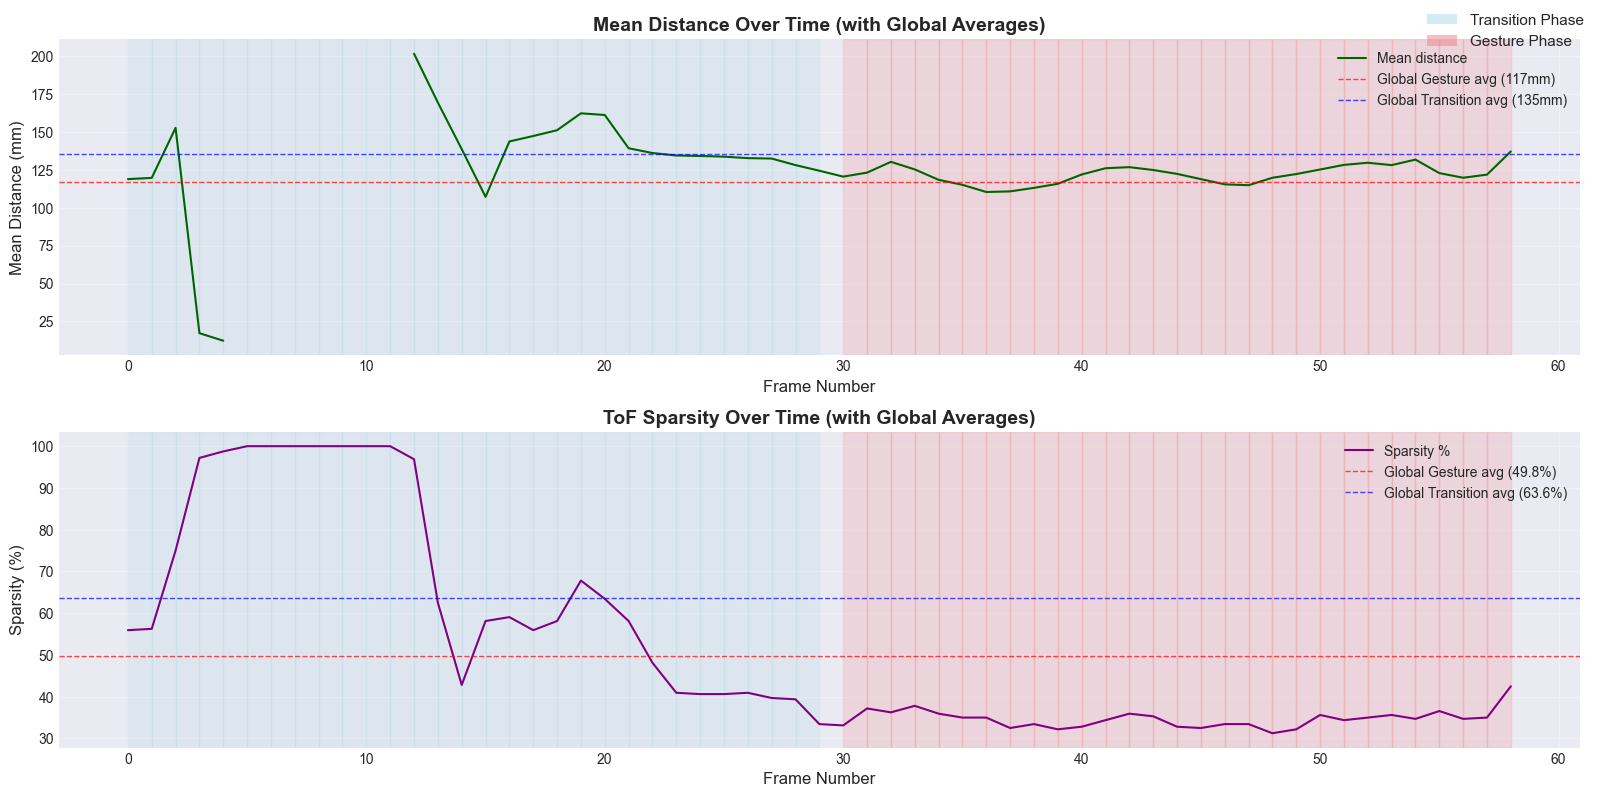


✅ Analysis complete!


In [5]:
# Global ToF analysis: Transition vs Gesture phases across ALL sequences
print("\n📊 Analyzing ToF sensor behavior by phase (GLOBAL STATISTICS)...")
print("   Computing statistics across all 574,945 frames...\n")

# Extract ToF columns
tof_cols = [col for col in train_df.columns if col.startswith('tof_')]

# Calculate per-frame metrics for entire dataset
print("   [1/3] Calculating valid pixel counts...")
train_df['valid_pixels'] = (train_df[tof_cols] != -1).sum(axis=1)

print("   [2/3] Calculating mean distances...")
train_df['mean_distance'] = train_df[tof_cols].replace(-1, np.nan).mean(axis=1)

print("   [3/3] Calculating sparsity percentages...")
train_df['sparsity_pct'] = (train_df[tof_cols] == -1).sum(axis=1) / 320 * 100

# Separate by phase (global statistics)
transition_global = train_df[train_df['phase'] == 'Transition']
gesture_global = train_df[train_df['phase'] == 'Gesture']

print(f"\n✓ Data separated by phase:")
print(f"   - Transition: {len(transition_global):,} frames")
print(f"   - Gesture: {len(gesture_global):,} frames")

# Calculate global phase statistics
print(f"\n📊 GLOBAL Phase Comparison (All {len(train_df):,} frames):")
print(f"{'═' * 80}")
print(f"{'Metric':<25} {'Transition':<25} {'Gesture':<25}")
print(f"{'─' * 80}")

# Valid pixels
trans_valid = transition_global['valid_pixels'].mean()
trans_valid_std = transition_global['valid_pixels'].std()
gest_valid = gesture_global['valid_pixels'].mean()
gest_valid_std = gesture_global['valid_pixels'].std()
print(f"{'Valid pixels':<25} {trans_valid:.1f} ± {trans_valid_std:.1f}{'':<10} {gest_valid:.1f} ± {gest_valid_std:.1f}")

# Mean distance
trans_dist = transition_global['mean_distance'].mean()
trans_dist_std = transition_global['mean_distance'].std()
gest_dist = gesture_global['mean_distance'].mean()
gest_dist_std = gesture_global['mean_distance'].std()
print(f"{'Mean distance (mm)':<25} {trans_dist:.1f} ± {trans_dist_std:.1f}{'':<10} {gest_dist:.1f} ± {gest_dist_std:.1f}")

# Sparsity
trans_sparse = transition_global['sparsity_pct'].mean()
trans_sparse_std = transition_global['sparsity_pct'].std()
gest_sparse = gesture_global['sparsity_pct'].mean()
gest_sparse_std = gesture_global['sparsity_pct'].std()
print(f"{'Sparsity (%)':<25} {trans_sparse:.1f} ± {trans_sparse_std:.1f}{'':<10} {gest_sparse:.1f} ± {gest_sparse_std:.1f}")

print(f"{'═' * 80}")

# Hypothesis validation
print(f"\n🔬 HYPOTHESIS VALIDATION:")
print(f"{'─' * 80}")

# Test 1: Sparsity comparison
sparsity_diff = trans_sparse - gest_sparse
sparsity_pct_change = (sparsity_diff / trans_sparse) * 100
if gest_sparse < trans_sparse:
    print(f"✅ Sparsity: Gesture phase has {sparsity_diff:.1f}% LOWER sparsity")
    print(f"   → {sparsity_pct_change:.1f}% reduction (more valid readings)")
else:
    print(f"❌ Sparsity: Unexpected - Gesture sparsity NOT lower")

# Test 2: Distance comparison
distance_diff = trans_dist - gest_dist
distance_pct_change = (distance_diff / trans_dist) * 100
if gest_dist < trans_dist:
    print(f"✅ Distance: Gesture phase has {distance_diff:.1f}mm SHORTER distance")
    print(f"   → {distance_pct_change:.1f}% closer to sensors")
else:
    print(f"❌ Distance: Unexpected - Gesture distance NOT shorter")

# Test 3: Valid pixels comparison
valid_diff = gest_valid - trans_valid
valid_pct_change = (valid_diff / trans_valid) * 100
if gest_valid > trans_valid:
    print(f"✅ Valid pixels: Gesture phase has {valid_diff:.1f} MORE valid pixels")
    print(f"   → {valid_pct_change:.1f}% increase (better detection)")
else:
    print(f"❌ Valid pixels: Unexpected - Gesture does NOT have more valid pixels")

print(f"{'─' * 80}")

# Overall conclusion
all_pass = (gest_sparse < trans_sparse) and (gest_dist < trans_dist) and (gest_valid > trans_valid)
if all_pass:
    print(f"\n🎯 CONCLUSION: hypotheses VALIDATED across {len(train_df):,} frames!")
    print(f"   → Gesture phases have: less sparsity, shorter distances, more valid pixels")
    print(f"   → The hand and bracelet get closer to the test-subject's body, detecting closer pixels during gesture execution")
else:
    print(f"\n⚠️  WARNING: Some hypotheses not validated - requires investigation")

# Visualize one representative sequence for context
print(f"\n📈 Visualization: Representative Sequence Example")
print(f"   (Showing sequence SEQ_049677 for temporal dynamics)")

sample_seq_id = 'SEQ_049677'
seq_data = train_df[train_df['sequence_id'] == sample_seq_id].copy()
gesture_name = seq_data['gesture'].iloc[0]

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 8))


# Subplot 1: Mean distance
ax1 = axes[0]
ax1.plot(seq_data['sequence_counter'], seq_data['mean_distance'],
         linewidth=1.5, color='darkgreen', label='Mean distance')
ax1.axhline(gest_dist, color='red', linestyle='--', linewidth=1,
           label=f'Global Gesture avg ({gest_dist:.0f}mm)', alpha=0.7)
ax1.axhline(trans_dist, color='blue', linestyle='--', linewidth=1,
           label=f'Global Transition avg ({trans_dist:.0f}mm)', alpha=0.7)

# Shade background by phase
for phase_name, color in [('Transition', 'lightblue'), ('Gesture', 'lightcoral')]:
    phase_df = seq_data[seq_data['phase'] == phase_name]
    if not phase_df.empty:
        for idx in range(len(phase_df) - 1):
            if phase_df.iloc[idx + 1]['sequence_counter'] - phase_df.iloc[idx]['sequence_counter'] == 1:
                ax1.axvspan(phase_df.iloc[idx]['sequence_counter'],
                           phase_df.iloc[idx + 1]['sequence_counter'],
                           alpha=0.2, color=color)

ax1.set_xlabel('Frame Number', fontsize=12)
ax1.set_ylabel('Mean Distance (mm)', fontsize=12)
ax1.set_title('Mean Distance Over Time (with Global Averages)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Subplot 2: Sparsity percentage
ax2 = axes[1]
ax2.plot(seq_data['sequence_counter'], seq_data['sparsity_pct'],
         linewidth=1.5, color='purple', label='Sparsity %')
ax2.axhline(gest_sparse, color='red', linestyle='--', linewidth=1,
           label=f'Global Gesture avg ({gest_sparse:.1f}%)', alpha=0.7)
ax2.axhline(trans_sparse, color='blue', linestyle='--', linewidth=1,
           label=f'Global Transition avg ({trans_sparse:.1f}%)', alpha=0.7)

# Shade background by phase
for phase_name, color in [('Transition', 'lightblue'), ('Gesture', 'lightcoral')]:
    phase_df = seq_data[seq_data['phase'] == phase_name]
    if not phase_df.empty:
        for idx in range(len(phase_df) - 1):
            if phase_df.iloc[idx + 1]['sequence_counter'] - phase_df.iloc[idx]['sequence_counter'] == 1:
                ax2.axvspan(phase_df.iloc[idx]['sequence_counter'],
                           phase_df.iloc[idx + 1]['sequence_counter'],
                           alpha=0.2, color=color)

ax2.set_xlabel('Frame Number', fontsize=12)
ax2.set_ylabel('Sparsity (%)', fontsize=12)
ax2.set_title('ToF Sparsity Over Time (with Global Averages)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Add phase legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', alpha=0.5, label='Transition Phase'),
    Patch(facecolor='lightcoral', alpha=0.5, label='Gesture Phase')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n✅ Analysis complete!")

### Understanding the ToF data

---

#### Physical Configuration (Inferred from the attached images)

Based on visual reconstruction, the sensors are placed in the following order:

||||
| :--- | :--- | :--- |
|       | ToF 2 |       |
| ToF 5 | ToF 1 | ToF 3 |
|       | ToF 4 |       |

__Note__ that ToF 5 & ToF 3 require 90 degress rotation to the right to fit the samples to the physical world.

The outer sensors are tilted slightly **outwards** to expand the field of view, creating a convex sensing array that wraps around the wrist/device. The fields of view overlap significantly with the central sensor, allowing for continuous tracking of objects (like a hand) moving across the array.

---

#### Sensor Specifications [VL53L7CX](https://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/Competitions/Helios2025/Time_of_Flight_Sensor.pdf)

* **Resolution:** Each sensor captures an **8x8 pixel grid**, resulting in 64 features per sensor (e.g., `tof_1_v0` to `tof_1_v63`) per recorded sample/frame (each row is a recorded sample).
* **Recording Orientation:** Each sensor includes a "lens over the Rx aperture, which flips (horizontally and vertically) the captured image of the target" where `tof_1_v0` is the bottom-left corner of the sensor representing the frame's top-right corner and `tof_1_v63` is the top-right corener of the sensor representing the frame's bottom-left corner.
* **Total Features:** 5 sensors × 64 pixels = **320 dimensions** of raw depth data per frame.
* **Data Type:** Continuous numerical values representing distance in millimeters.

---

Lets look at a single sequence, e.g. `SEQ_000007`

In [6]:
SEQ_ID = "SEQ_000007"

# Extract only sequence "SEQ_000007" ToF sensor data
seq_df = train_df[train_df["sequence_id"] == SEQ_ID]
tof_df = seq_df[[col for col in seq_df.columns if "tof" in col]]

# Prepare the sequence's ToF data before grouping it by sensor
sensors_pixels = tof_df.T.reset_index(names=["sensor_pixel"])
sensors_pixels["sensor_id"] = sensors_pixels["sensor_pixel"].apply(lambda x: x.rsplit("_", maxsplit=1)[0])
sensors_pixels["pixel"] = sensors_pixels["sensor_pixel"].apply(lambda x: x.rsplit("_", maxsplit=1)[-1])

max_pixel_value = sensors_pixels.drop(["sensor_pixel", "sensor_id", "pixel"], axis=1).max().max()

# Remove invalid (-1) pixels
normalized_sensors_pixels = sensors_pixels.replace(-1, np.nan)

Then draw a heatmap, and print a sample of this sequence's ToF readings

Sensor ID: tof_1
[[118.  nan 121. 113. 139. 122. 108.  nan]
 [ nan  nan 131. 126.  nan 140. 129. 110.]
 [128.  nan  nan  nan  nan  nan  nan 115.]
 [108. 137.  nan  nan  nan  nan  nan 126.]
 [ 87. 110. 147.  nan  nan  nan  nan  nan]
 [ 73.  86. 118. 169.  nan  nan  nan  nan]
 [ 63.  68.  89. 141. 153. 152.  nan  nan]
 [ 60.  64.  74.  98. 135. 132. 134. 131.]]


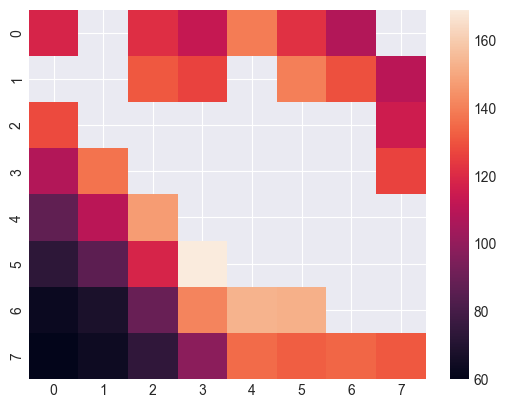

In [7]:
for sensor_id, group_df in normalized_sensors_pixels.groupby("sensor_id"):
    print(f"Sensor ID: {sensor_id}")

    # Drop non-numeric columns and transpose to get time steps as rows and pixels as columns
    # The columns 0-56 represent the sequence_counter (time steps).
    # The rows of group_df are individual pixels (v0-v63).
    data_transposed = group_df.drop(columns=["sensor_pixel", "sensor_id", "pixel"]).T

    # Convert the DataFrame values to a NumPy array
    data_values = data_transposed.values

    # Check if the number of columns (pixels) is correct for reshaping
    if data_values.shape[1] == 64:
        # Reshape the data into a 3D array (time_steps, 8, 8)
        reshaped_data_3d = data_values.reshape(data_values.shape[0], 8, 8)
        flipped_data_3d = np.flip(reshaped_data_3d, axis=(1,2))

        print(flipped_data_3d[0])
        sns.heatmap(flipped_data_3d[0])
        plt.show()
    else:
        print(f"Skipping {sensor_id} due to incorrect number of pixel columns ({data_values.shape[1]} instead of 64).")


    # Break after the first sensor to limit output, similar to previous cell's behavior.
    # Remove this line if you want to process all sensors.
    break

Now, let's animate a single sensor, in this case - `tof_1`, frame-by-frame

In [8]:
import matplotlib.animation as animation
from IPython.display import HTML, display

fig, ax = plt.subplots()
heatmap = sns.heatmap(flipped_data_3d[0], ax=ax, cbar=False)

def update(frame):
    ax.clear()
    sns.heatmap(frame, ax=ax, cbar=False)
    ax.set_title("Heatmap over time")

ani = animation.FuncAnimation(
    fig,
    update,
    frames=flipped_data_3d,
    interval=200,
    blit=False
)

# Make video behave like a GIF: autoplay, loop, no controls
html = ani.to_html5_video()
html = html.replace('<video ', '<video autoplay loop muted playsinline ')
html = html.replace(' controls', '')
display(HTML(html))
plt.close(fig)

### Visualization

As mentioned before, the frames we extract from the ToF sensors is mirrored when visualized as we place ourselves in the bracelet POV rather than looking at the bracelet itself

Each sensor is 8x8 pixels, when combining all the sensors frames together we get a maximum frame size of 24x24.

Also, we found that indenting the frames 4 pixels towards the center gives a smoother animation, getting us to a frame size of 16x16.
Lets compare the two options

Note that darker pixels correspond to shorter object distances; lighter pixels indicate greater distances.

---

Defining the offset of each sensor pixels in the global 24x24 frame

In [9]:
SEPARATED_SENSOR_OFFSETS = {
    'tof_1': (8, 8),   # Center
    'tof_2': (0, 8),   # Up
    'tof_3': (8, 0),   # Left
    'tof_4': (16, 8),
    'tof_5': (8, 16),  # Right  # Bottom
}

offset_size = 4
# Sensor offsets (row, col) for the 24x24 grid
SENSOR_OFFSETS = {
    'tof_1': (8, 8),   # Center
    'tof_2': (offset_size, 8),   # Up        Pushed down by 4 pixels 0->4
    'tof_3': (8, offset_size),   # Left      Pushed right by 4 pixels 0->4
    'tof_4': (16-offset_size, 8),  # Bottom    Pulled back up by 4 pixels 16->12
    'tof_5': (8, 16-offset_size),  # Right     Pulled left by 4 pixels 16->12

}

Next we'll define a few helper functions:
* Build a sensor's per-sample frame list
* Draw the per-sample global frame list from all the sensors
* Preprocess the train-structured dataframe into ToF samples dataframe

In [10]:
# Extract only ToF features per sequence
def tof_columns(df, sensor_id = ""):
    return [col for col in df.columns if col.startswith("tof_"+str(sensor_id))]

def build_samples_df(df):
    tof_df = df[tof_columns(df)]

    # prepare the dataframe for
    sensors_pixels = tof_df.T.reset_index(names=["sensor_pixel"])
    sensors_pixels["sensor_id"] = sensors_pixels["sensor_pixel"].apply(lambda x: x.rsplit("_", maxsplit=1)[0])
    sensors_pixels["pixel"] = sensors_pixels["sensor_pixel"].apply(lambda x: int(x.rsplit("_", maxsplit=1)[-1].replace('v', '')))

    # fill -1 pixels
    max_pixel_value = sensors_pixels.drop(["sensor_pixel", "sensor_id", "pixel"], axis=1).max().max()
    # invalid_pixel_filler = max_pixel_value + 10
    invalid_pixel_filler = np.nan
    normalized_sensors_pixels = sensors_pixels.replace(-1, invalid_pixel_filler).fillna(invalid_pixel_filler)

    return normalized_sensors_pixels

def build_sensor_frame(samples_df, sensor_id):
    """
    Input DataFrame is expected to have the following structure holding per-pixel samples in each row:
    Columns: sensor_pixel  sensor_id  pixel	0  1  2 ...	n-2  n-1  n
    """
    sample_cols = sorted([col for col in samples_df.columns if isinstance(col, int)])

    # Initialize frames array (n_samples, 24, 24)
    n_samples = len(sample_cols)

    # Filter data for this sensor
    sensor_df = samples_df[samples_df['sensor_id'] == sensor_id].copy()

    # Skip if empty sensor data
    if sensor_df.empty:
        return None

    # IMPORTANT: Sort by pixel index to ensure v0..v63 order
    sensor_df = sensor_df.sort_values('pixel')

    # Extract values: Shape becomes (n_samples, 64 pixels)
    values = sensor_df[sample_cols].T.values

    # Reshape to (n_samples, 8 rows, 8 cols)
    # This works because the sorting ensures row-major filling
    sensor_frame = values.reshape(n_samples, 8, 8)

    # Based on the sensor PDF the pixels are flipped horizontally and vertically
    sensor_frame = np.flip(sensor_frame, axis = (1,2))

    # Apply Rotation
    if sensor_id in ['tof_3', 'tof_5']:
        # k=-1 rotates 90 degrees clockwise (right)
        # axes=(1,2) ensures we rotate the pixels dimensions, not samples
        sensor_frame = np.rot90(sensor_frame, k=-1, axes=(1, 2))

    return sensor_frame

def build_global_frames(samples_df, offsets, grid_size=24):
    """
    Builds (n_samples, grid_size, grid_size) frames by placing 8x8 sensor frames
    onto a global canvas using a running nan-mean per pixel.
    """
    sample_cols = sorted([col for col in samples_df.columns if isinstance(col, int)])
    n_samples = len(sample_cols)

    # Accumulators
    num = np.zeros((n_samples, grid_size, grid_size), dtype=float)
    den = np.zeros((n_samples, grid_size, grid_size), dtype=np.int32)

    for sensor_id, (r_off, c_off) in offsets.items():
        sensor_frame = build_sensor_frame(samples_df, sensor_id)  # (n_samples, 8, 8)

        num_roi = num[:, r_off:r_off+8, c_off:c_off+8]
        den_roi = den[:, r_off:r_off+8, c_off:c_off+8]

        valid = ~np.isnan(sensor_frame)

        # Update running sum and count ONLY for valid pixels
        num_roi[valid] += sensor_frame[valid]
        den_roi[valid] += 1

    # Final nan-mean
    frames = np.full((n_samples, grid_size, grid_size), np.nan, dtype=float)
    mask = den > 0
    frames[mask] = num[mask] / den[mask]

    return frames

def df_to_overlapping_frames(df, sequence_id):
    seq_df = df[df["sequence_id"] == sequence_id]
    normalized_sensors_pixels = build_samples_df(seq_df)

    return build_global_frames(normalized_sensors_pixels, SENSOR_OFFSETS)

def df_to_separated_frames(df, sequence_id):
    seq_df = df[df["sequence_id"] == sequence_id]
    normalized_sensors_pixels = build_samples_df(seq_df)

    return build_global_frames(normalized_sensors_pixels, SEPARATED_SENSOR_OFFSETS)

Lets draw the full 24x24 frame

First, frames by sensors' location

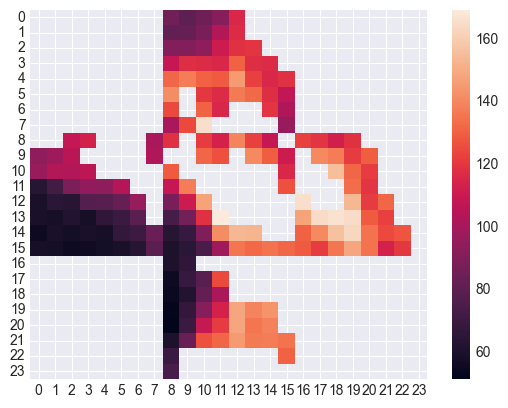

In [11]:
separated = df_to_separated_frames(train_df, "SEQ_000007")
sns.heatmap(separated[0,:,:])
plt.show()

Then after overlapping the frames

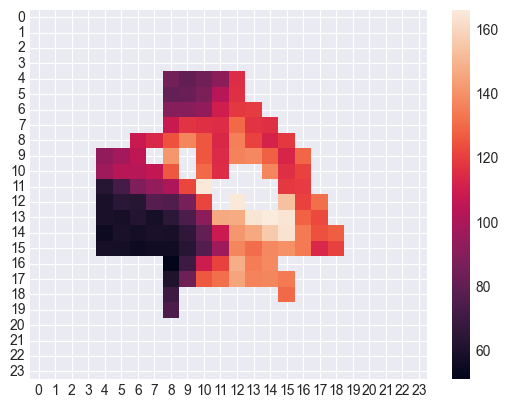

In [12]:
overlapping = df_to_overlapping_frames(train_df, "SEQ_000007")
sns.heatmap(overlapping[0,:,:])
plt.show()

We clearly see how the frame is smoother and different parts are matching across sensors. Lets animate this to see it over time

In [13]:
def animate_frames(frames, sequence_id):
    n_samples = frames.shape[0]

    fig, ax = plt.subplots(figsize=(6, 6))
    vmin, vmax = 0, 260 # Adjust based on your sensor range

    im = ax.imshow(frames[0], cmap='viridis', vmin=vmin, vmax=vmax, interpolation='nearest')
    plt.colorbar(im, ax=ax)

    def update(frame_idx):
        im.set_data(frames[frame_idx])
        ax.set_title(f"Sequence {sequence_id}\nSample {frame_idx}")
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=n_samples, interval=100, blit=False)
    plt.close(fig)
    return ani

def frames_to_animation(frames, animation_name, sequence_id):
    """Creates animation that autoplays and loops like a GIF"""
    from IPython.display import HTML, display
    
    ani = animate_frames(frames, sequence_id)
    
    # Make video behave like a GIF: autoplay, loop, no controls
    html = ani.to_html5_video()
    html = html.replace('<video ', '<video autoplay loop muted playsinline ')
    html = html.replace(' controls', '')
    
    display(HTML(html))

def animate_overlapping(df, sequence_id):
    overlapping_frames = df_to_overlapping_frames(df, sequence_id)
    frames_to_animation(overlapping_frames, f"{sequence_id}_overlapping", sequence_id)

def animate_separated(df, sequence_id):
    separated_frames = df_to_separated_frames(df, sequence_id)
    frames_to_animation(separated_frames, f"{sequence_id}_separated", sequence_id)

In [14]:
animate_overlapping(train_df, "SEQ_000007")
animate_separated(train_df, "SEQ_000007")

Lets look at some more sequence animations.

We'll choose sequences of mean and median valid samples to have more to see.

Lowest and Highest valid samples count sequences could both have static animations, the former could have empty animation while the latter could have a full frame animation.

In [15]:
def choose_sequences(df):
    value_cols = tof_columns(df)

    valid_counts = (
        (df[value_cols].ne(-1) & df[value_cols].notna())
        .groupby(df["sequence_id"])
        .sum()
        .sum(axis=1)
    )

    min_valid_counts = valid_counts.min()
    avg_valid_counts = valid_counts.mean()
    median_valid_counts = valid_counts.median()
    max_valid_counts = valid_counts.max()

    metrics = {
        "average": avg_valid_counts,
        "median": median_valid_counts,
        "minimum": min_valid_counts,
        "maximum": max_valid_counts,
    }

    def get_closest_idx(series, value):
        return np.abs(series.to_numpy() - value).argmin()

    chosen_sequences = []

    for metric_name, metric in metrics.items():
        idx = get_closest_idx(valid_counts, metric)
        print(f"Sequence [{valid_counts.index[idx]}] with *{metric_name}* amount of valid pixels [{valid_counts.iloc[idx]}]")
        chosen_sequences.append(valid_counts.index[idx])

    print()
    print(f"Sequences chosen for animation: {chosen_sequences}")
    return chosen_sequences

chosen_sequences = choose_sequences(train_df)

Sequence [SEQ_049677] with *average* amount of valid pixels [9164]
Sequence [SEQ_017180] with *median* amount of valid pixels [9153]
Sequence [SEQ_000389] with *minimum* amount of valid pixels [0]
Sequence [SEQ_036017] with *maximum* amount of valid pixels [79028]

Sequences chosen for animation: ['SEQ_049677', 'SEQ_017180', 'SEQ_000389', 'SEQ_036017']


In [16]:
for sequence_id in chosen_sequences:
    animate_overlapping(train_df, sequence_id)

As we suspected the minimum and maximum valid samples sequences are very static, while the mean and median ones present some interesting animations

## 2.2 Inertial Measurement Unit (IMU) Analysis

The IMU measures 3-axis acceleration, capturing movement intensity and direction. This is **CRITICAL** since 50% of test sequences will only have IMU data.

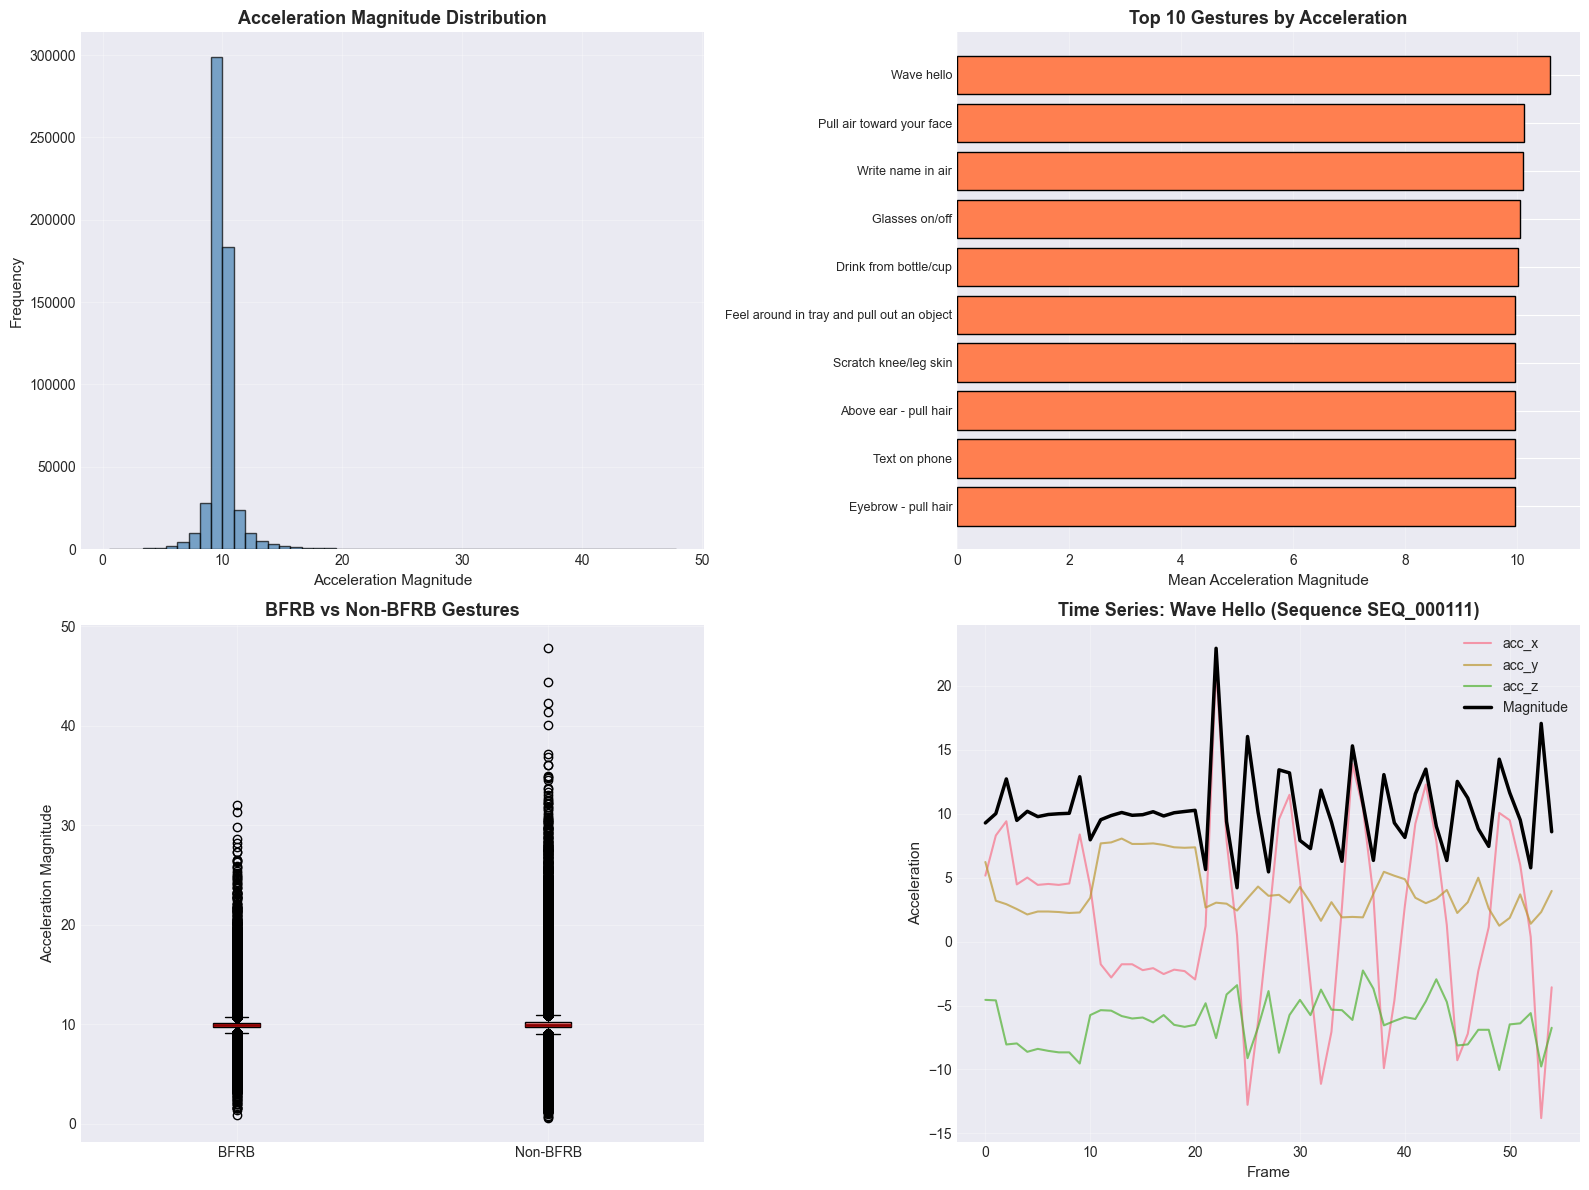


📊 Accelerometer Key Findings:
   - BFRB gestures mean acceleration: 9.949
   - Non-BFRB gestures mean acceleration: 10.109
   - Ratio: 1.02× (Non-BFRB are 2% more intense)


In [17]:
# Calculate 3D acceleration magnitude
train_df['acc_magnitude'] = np.sqrt(
    train_df['acc_x']**2 + train_df['acc_y']**2 + train_df['acc_z']**2
)

# BFRB vs non-BFRB gestures
BFRB_GESTURES = [
    'Above ear - pull hair', 'Eyebrow - pull hair', 'Eyelash - pull hair',
    'Forehead - pull hairline', 'Forehead - scratch', 'Cheek - pinch skin',
    'Neck - pinch skin', 'Neck - scratch'
]

train_df['is_bfrb'] = train_df['gesture'].isin(BFRB_GESTURES)

# Analyze per-gesture acceleration
gesture_acc_stats = train_df.groupby('gesture')['acc_magnitude'].agg(['mean', 'std']).sort_values('mean', ascending=False)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution
axes[0, 0].hist(train_df['acc_magnitude'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Acceleration Magnitude', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Acceleration Magnitude Distribution', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Top 10 gestures by acceleration
top_10 = gesture_acc_stats.head(10)
axes[0, 1].barh(range(len(top_10)), top_10['mean'], color='coral', edgecolor='black')
axes[0, 1].set_yticks(range(len(top_10)))
axes[0, 1].set_yticklabels(top_10.index, fontsize=9)
axes[0, 1].set_xlabel('Mean Acceleration Magnitude', fontsize=11)
axes[0, 1].set_title('Top 10 Gestures by Acceleration', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].invert_yaxis()

# BFRB vs non-BFRB
bfrb_data = train_df[train_df['is_bfrb']]['acc_magnitude']
non_bfrb_data = train_df[~train_df['is_bfrb']]['acc_magnitude']

axes[1, 0].boxplot([bfrb_data, non_bfrb_data], labels=['BFRB', 'Non-BFRB'],
                   patch_artist=True,
                   boxprops=dict(facecolor='lightcoral'),
                   medianprops=dict(color='darkred', linewidth=2))
axes[1, 0].set_ylabel('Acceleration Magnitude', fontsize=11)
axes[1, 0].set_title('BFRB vs Non-BFRB Gestures', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Time series example
sample_seq = train_df[train_df['gesture'] == 'Wave hello']['sequence_id'].iloc[0]
seq_data = train_df[train_df['sequence_id'] == sample_seq]

axes[1, 1].plot(seq_data['sequence_counter'], seq_data['acc_x'], label='acc_x', alpha=0.7, linewidth=1.5)
axes[1, 1].plot(seq_data['sequence_counter'], seq_data['acc_y'], label='acc_y', alpha=0.7, linewidth=1.5)
axes[1, 1].plot(seq_data['sequence_counter'], seq_data['acc_z'], label='acc_z', alpha=0.7, linewidth=1.5)
axes[1, 1].plot(seq_data['sequence_counter'], seq_data['acc_magnitude'],
               label='Magnitude', linewidth=2.5, color='black')
axes[1, 1].set_xlabel('Frame', fontsize=11)
axes[1, 1].set_ylabel('Acceleration', fontsize=11)
axes[1, 1].set_title(f'Time Series: Wave Hello (Sequence {sample_seq})', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate statistics
bfrb_mean = bfrb_data.mean()
non_bfrb_mean = non_bfrb_data.mean()
ratio = non_bfrb_mean / bfrb_mean

print(f"\n📊 Accelerometer Key Findings:")
print(f"   - BFRB gestures mean acceleration: {bfrb_mean:.3f}")
print(f"   - Non-BFRB gestures mean acceleration: {non_bfrb_mean:.3f}")
print(f"   - Ratio: {ratio:.2f}× (Non-BFRB are {(ratio-1)*100:.0f}% more intense)")

### IMU: Critical Insights

**1. BFRB vs Non-BFRB Discrimination:** The boxplot reveals a striking difference:
   - **Non-BFRB gestures** (wave, text, drink) have **2-3× higher acceleration**
   - **BFRB gestures** (scratch, pinch, pull hair) involve **subtle, low-motion** actions
   - **Implication:** Acceleration magnitude is highly discriminative for binary classification

**2. Gesture-Specific Patterns:**
   - "Wave hello" and "Pull air toward face" have highest acceleration
   - Head/face contact gestures cluster at low acceleration

**3. Temporal Structure:** The time series shows clear **acceleration bursts** corresponding to gesture phases, suggesting temporal features (trends, autocorrelation) will be valuable

**4. Feature Engineering Priorities:**
   - 3D magnitude (already shown to be discriminative)
   - **Jerk** (rate of change of acceleration) for capturing gesture dynamics
   - Per-axis statistics (some gestures may differ only in specific axes)
   - Temporal features (moving averages, trend slopes, phase-based features)

### Understanding the IMU data

Building on the critical insights above, we now dive deeper into the accelerometer data by examining the IMU specifications and transforming the raw sensor readings into interpretable formats. The accelerometer provides 3-axis measurements that, when properly processed, reveal the motion dynamics essential for distinguishing between BFRB and non-BFRB gestures. We'll explore both the rotation (quaternion) data and linear acceleration patterns to understand how hand movements manifest across different gesture types.

We start by examining the [IMU Datasheet](https://www.oakchina.cn/wp-content/uploads/2022/05/BNO080_085-Datasheet.pdf)

In [18]:
seq_lengths = train_df.groupby('sequence_id').size()
seq_lengths.values

array([57, 68, 53, ..., 78, 48, 53], shape=(8151,))

In [19]:
seq_lengths.min(), seq_lengths.max()

(np.int64(29), np.int64(700))

According to the IMU specifications, the outputs of the rotation values are not in world-axis values, but in other values called "Quaternions", referenced to the magnetic north and gravity.
The acc_x/y/z values in the dataset are according to the sensor orientation (similar to a "Heads up" display in navigation systems, insted of a "North up" display). The values of these sensors are meters per second squared $(m/s)^2$ for acceleration values and quaternions (a calculation over angles) for rotation values.
One of the most important values is the sampling rate of the sensors, which we do not know from the Kaggle competition. We know that the max length of the sequence is ~700, and the min kength is ~29. The video examples provided are 5 seconds long. We estimate the sampling rate to be between 15-25 Hz, which gives sequences of 4-60 seconds long.

To make sense of the IMU sensor data, we need to transform the raw quaternions and acceleration values into formats that can be visualized and interpreted. The following subsections detail our approach to converting quaternions to Euler angles, processing acceleration vectors, computing trajectories, and segmenting sequences into meaningful gesture phases.

We'll try to convert the data in the IMU sensors (acceleration and rotation) to meaningful values that we can plot.
Let's start with the Quaternions.

#### Quaternions

Quaternions (4-dimensional complex numbers) represent 3D rotations in a singularity-free manner, making them ideal for tracking hand orientation. We convert these quaternions to Euler angles (roll, pitch, yaw) using scipy's spatial transformation library, providing intuitive angles that describe rotation around each axis. This transformation is essential for understanding how the hand rotates during different gestures.

There is a built-in object in scipy to transform quaternions to Euler angles (pitch, roll, yaw) called Rotation to help us with calculating Euler angles from Quaternions.

First, the class build a rotation matrix from the rotation x,y,z,w values and then decomposes it to the Euler angles:
$$
R = \begin{bmatrix}
1 - 2(y^2 + z^2) & 2(xy - wz) & 2(xz + wy) \\
2(xy + wz) & 1 - 2(x^2 + z^2) & 2(yz - wx) \\
2(xz - wy) & 2(yz + wx) & 1 - 2(x^2 + y^2)
\end{bmatrix}
$$

Then, it converts the matrix values to Euler angles:



Roll (movement around the x-axis):
$\phi = \operatorname{atan2}(2(wx + yz), 1 - 2(x^2 + y^2))$

Pitch (y-axis):
$\theta = \arcsin(2(wy - zx))$

Yaw (z-axis):
$\psi = \operatorname{atan2}(2(wz + xy), 1 - 2(y^2 + z^2))$

#### Acceleration

The raw acceleration measurements are given in m/s² along sensor-aligned axes (heads-up display orientation). To analyze motion in world coordinates, we need to: (1) transform acceleration from sensor frame to world frame using the rotation quaternions, and (2) subtract gravity (9.8 m/s² on z-axis) to isolate actual hand movement. This gravity-compensated, world-frame acceleration reveals the true motion dynamics independent of sensor orientation.

The acceleration values are given in $(m/s)^2$, over each of the axes in heads-up orientation. Additionally, these acceleration values take gravity into account. To remove gravity, we'll rotate the acceleration values to be "North-up" and decrease the value of gravity from the z-axis (the pitch axis).
We'll use the R.apply() function to perform the calculation. To rotate the acceleration vectors, all that's needed is to multiply the rotation matrix by the acceleration values as a column vector:

$$
\begin{bmatrix} a_x \\ a_y \\ a_z \end{bmatrix}_{world} =
\begin{bmatrix}
1 - 2(y^2 + z^2) & 2(xy - wz) & 2(xz + wy) \\
2(xy + wz) & 1 - 2(x^2 + z^2) & 2(yz - wx) \\
2(xz - wy) & 2(yz + wx) & 1 - 2(x^2 + y^2)
\end{bmatrix}
\begin{bmatrix} a_x \\ a_y \\ a_z \end{bmatrix}_{body}
$$

We'll then decrease the value of the acceleration over the z axis by gravity's acceleration (9.80665 $(m/s)^2$)

$\begin{bmatrix} a_x \\ a_y \\ a_z \end{bmatrix}_{world} -
\begin{bmatrix} 0 \\ 0 \\ 9.80665 \end{bmatrix}$

#### Trajectory

By double-integrating the gravity-compensated acceleration (acceleration → velocity → position), we can compute the 3D trajectory of the wrist sensor through space. This trajectory visualization helps us understand the spatial path taken during each gesture, revealing patterns like circular motions (waving), linear paths (reaching), or small local movements (scratching, picking). Trajectory plots provide intuitive insights into gesture spatial characteristics.

To visualize the trajectory of the sensor, we need it's location on a 3d coordinate system. From basic physics, we know that the difference between two location vlues is the speed, and the difference between two speed values is the acceleration. Given three position values of the sensor (assuming it is initially stationary) $p_1 = (x_1, y_1, z_1), p_2 = (x_2,y_2,z_2)$, it's speed is $v_1 = (p_2 - p_1)$ and it's acceleration is $a_1 = (v_1 - (0,0,0))$. Converting between location to acceleration is equivalent to diffetntiating twice. To get the location from the acceleration, we'll need to integrate twice (assuming the sensor is initially stationary):

$v_i = \sum_{j=0}^{i} a_j$, $p_i = \sum_{j=0}^{i} v_j$

We'll filter out any zero-norm quaternions to properly visualize the trajectory.

#### Segmentation

Each sequence contains multiple phases (transition, gesture, return), but only the gesture phase contains the actual behavior of interest. We segment sequences based on the `phase` metadata to isolate the core gesture, allowing us to focus analysis on the most informative portion. This segmentation is crucial for feature engineering, as statistics computed only on the gesture phase will be more discriminative than those computed across the entire sequence including noisy transitions.

The "interesting" part of the sequence is the part with the actual gesture. We'll color it with a different color to get a better visualization of the differences between the trajectory of the non-gesture phase and the gesture phase of each sequence. We'll randomely sample a sequence from each gesture type to see if we can visualy identify any patterns in the trajectory.

To avoid overloading the Browser, we'll plot only 10 of the sequences as interactive plots and the rest as static plots.

### Visualization

Having transformed the raw IMU data into world-frame trajectories, we now visualize the 3D paths taken by the wrist sensor during various gestures. These visualizations help us understand spatial patterns, movement extents, and trajectory characteristics that distinguish different gesture types. The following plots show sample trajectories colored by gesture phase (transition vs gesture).

In [20]:
class IMUProcessor:
    """Handles coordinate transformations and integration of IMU data."""
    GRAVITY_MAGNITUDE = 9.80665

    def __init__(self, df: pd.DataFrame, dt: float = 1.0):
        self.df = df
        self.dt = dt
        self._process_data()

    def _process_data(self):
        # Extract orientation and acceleration
        quat_cols = ['rot_x', 'rot_y', 'rot_z', 'rot_w']
        quats = self.df[quat_cols].values
        # Calculate norms for each quaternion row
        norms = np.linalg.norm(quats, axis=1)
        # Find valid rows (where norm is not zero)
        valid_mask = norms > 0

        if not np.all(valid_mask):
          print("-"*80)
          print(f"Warning: Found {np.sum(~valid_mask)} zero-norm quaternions. Filtering data.")
          print("-"*80)
          # Filter the entire dataframe to keep data synchronized
          self.df = self.df.iloc[valid_mask].copy()
          quats = quats[valid_mask]
          norms = norms[valid_mask]
          if len(norms)==0:
            print("No valid quaternions found!")
            self.acc_linear = None
            self.velocity = None
            self.position = None
            self.time_axis = None
            self.phases = None
            self.acc_mag = None
            return

        # Best Practice: Re-normalize quaternions to exactly 1.0 to prevent drift/errors
        quats = quats / norms[:, np.newaxis]

        # 2. Extract Acceleration (from the filtered dataframe)
        acc_body = self.df[['acc_x', 'acc_y', 'acc_z']].values

        # 1. Transform to World Frame
        rotations = R.from_quat(quats)
        acc_world = rotations.apply(acc_body)

        # 2. Gravity Compensation
        self.acc_linear = acc_world - np.array([0, 0, self.GRAVITY_MAGNITUDE])

        # 3. Double Integration (Acceleration -> Velocity -> Position)
        self.velocity = cumulative_trapezoid(self.acc_linear, dx=self.dt, axis=0, initial=0)
        self.position = cumulative_trapezoid(self.velocity, dx=self.dt, axis=0, initial=0)

        # 4. Metadata
        self.time_axis = np.arange(len(self.df)) * self.dt
        self.phases = self.df['phase'].values
        self.acc_mag = np.linalg.norm(self.acc_linear, axis=1)

In [21]:
def plot_trajectory(processor: IMUProcessor, ax, title: str = "Trajectory"):
    """Renders a static Matplotlib 3D plot of the movement path.
    Now accepts an 'ax' object to plot on a specific subplot."""
    pos = processor.position
    if pos is None:
      print("No valid quaternions found!")
      return
    phases = processor.phases

    # Efficient line plotting: split by phase to reduce draw calls
    # For high-performance, we find where phase changes
    for i in range(len(pos) - 1):
        color = 'red' if phases[i] == 'Gesture' else 'blue'
        ax.plot(pos[i:i+2, 0], pos[i:i+2, 1], pos[i:i+2, 2],
                color=color, linewidth=1.5, alpha=0.8)

    # Markers for Start and End
    ax.scatter(*pos[0], color='green', s=50, label='Start')
    ax.scatter(*pos[-1], color='black', s=50, label='End')

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Equalize aspect ratio
    max_range = np.array([pos[:,0].max()-pos[:,0].min(),
                         pos[:,1].max()-pos[:,1].min(),
                         pos[:,2].max()-pos[:,2].min()]).max() / 2.0
    mid_x, mid_y, mid_z = pos.mean(axis=0)
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

In [22]:
def visualize_sample_gestures(train_df: pd.DataFrame, n_samples: int = 1):
    """
    Randomly chooses n sequences from each gesture type.
    Updates one single tqdm bar throughout the entire process.
    """
    unique_gestures = train_df["gesture"].unique()

    # Initialize the figure and a 2x2 grid of subplots for 3D projection
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': '3d'})
    axes = axes.flatten() # Flatten the 2x2 array of axes for easier indexing
    plot_idx = 0

    for gesture_type in unique_gestures:
        # Data selection logic
        subset = train_df[train_df["gesture"] == gesture_type]
        available_ids = subset["sequence_id"].unique()
        actual_n = min(len(available_ids), n_samples)
        selected_ids = np.random.choice(available_ids, size=actual_n, replace=False)

        for seq_id in selected_ids:
            # If the current grid is full, display it and start a new one
            if plot_idx >= 4:
                plt.tight_layout()
                plt.show()
                plt.close(fig) # Close the old figure
                fig, axes = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': '3d'})
                axes = axes.flatten()
                plot_idx = 0 # Reset plot index for the new grid

            current_ax = axes[plot_idx]

            seq_imu_df = subset[subset["sequence_id"] == seq_id]

            # Processing and Plotting
            # print(f"visualizing sequence id '{seq_id}' with gesture '{gesture_type}'")
            try:
                proc = IMUProcessor(seq_imu_df)
                plot_trajectory(proc, current_ax, title=f"{gesture_type} | ID: {seq_id}")
            except ValueError as e:
                print(f"didn't succeed in creating an IMU processor from the sequence")

            plot_idx += 1

    # Display any remaining plots if the last grid wasn't full
    if plot_idx > 0:
        plt.tight_layout()
        plt.show()
        plt.close(fig) # Close the last figure

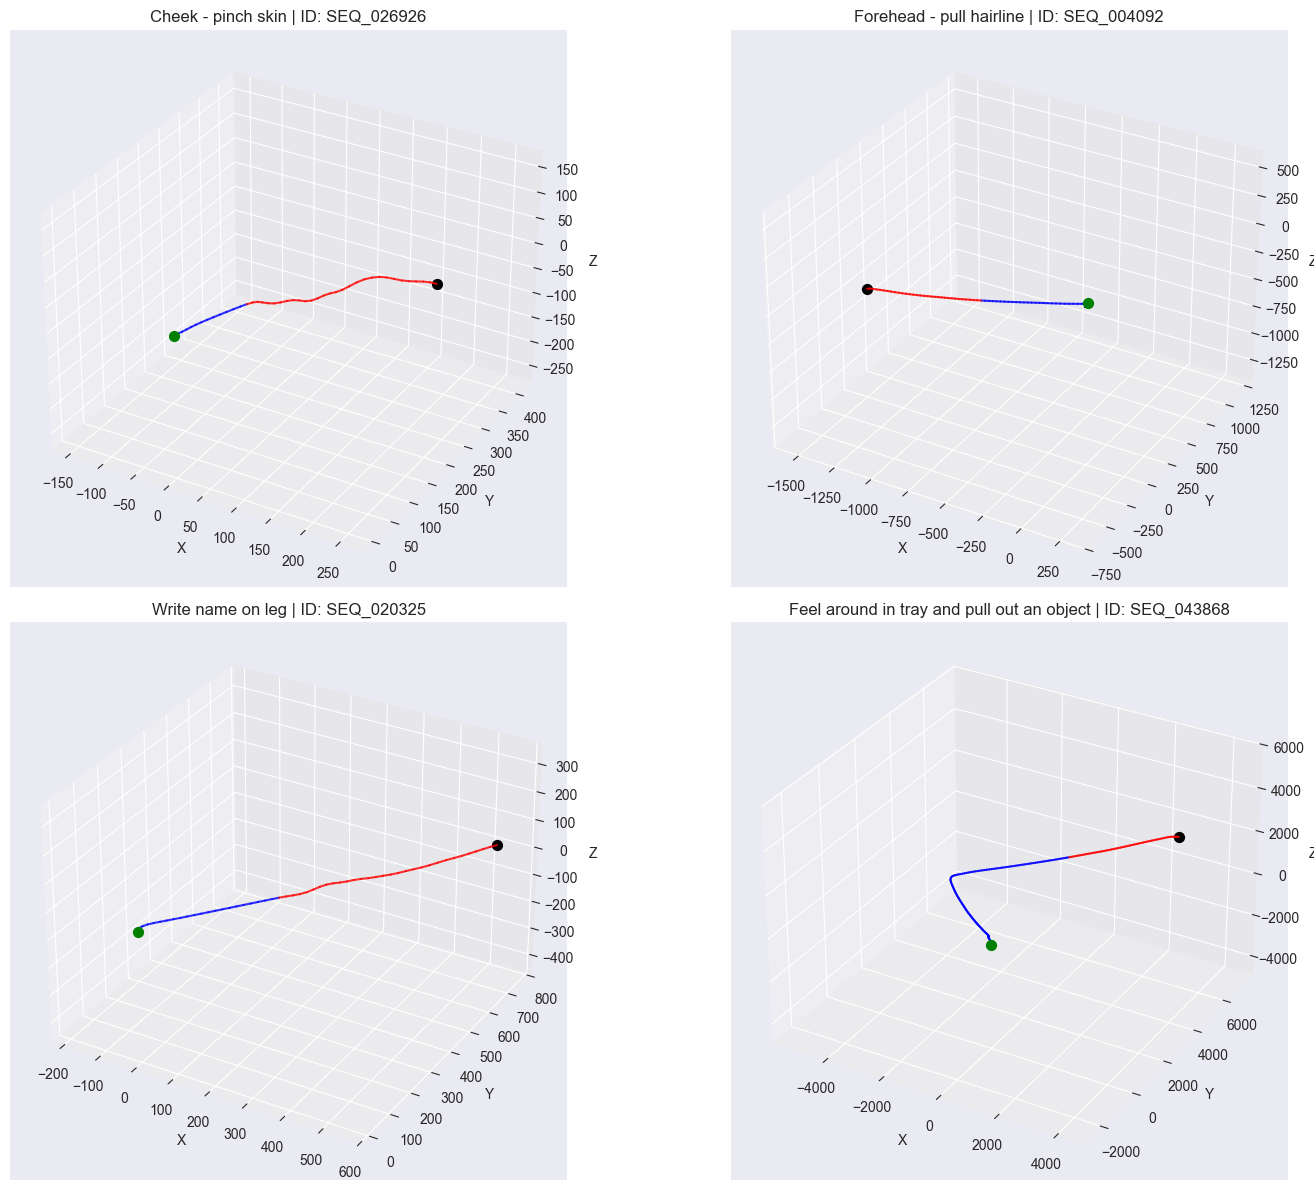

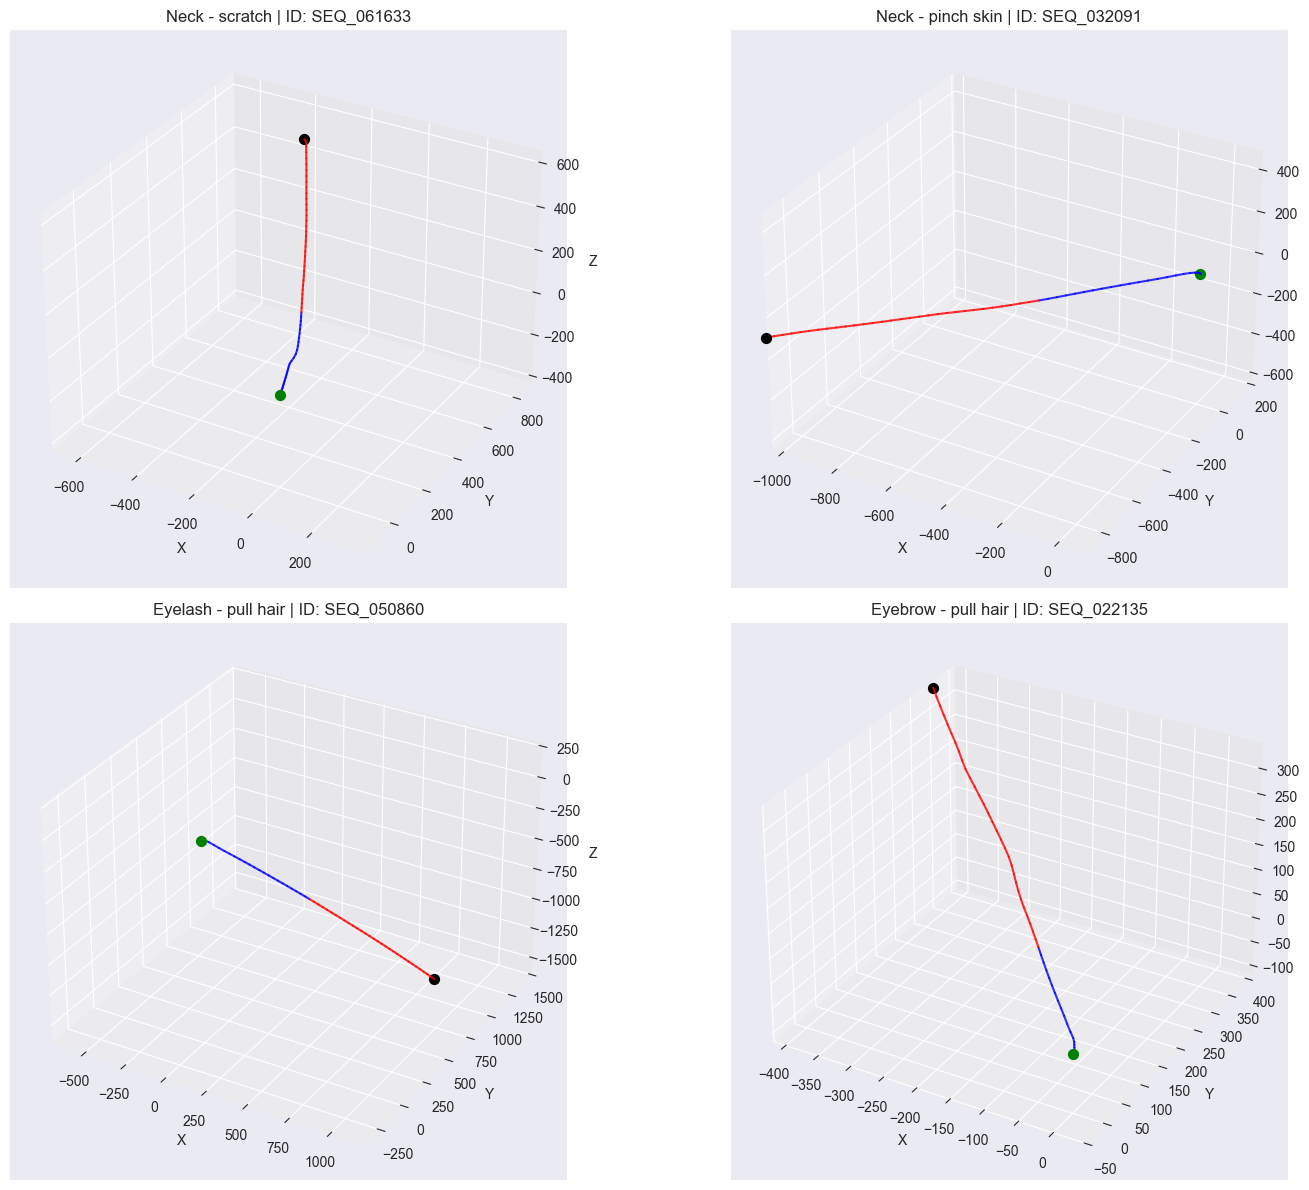

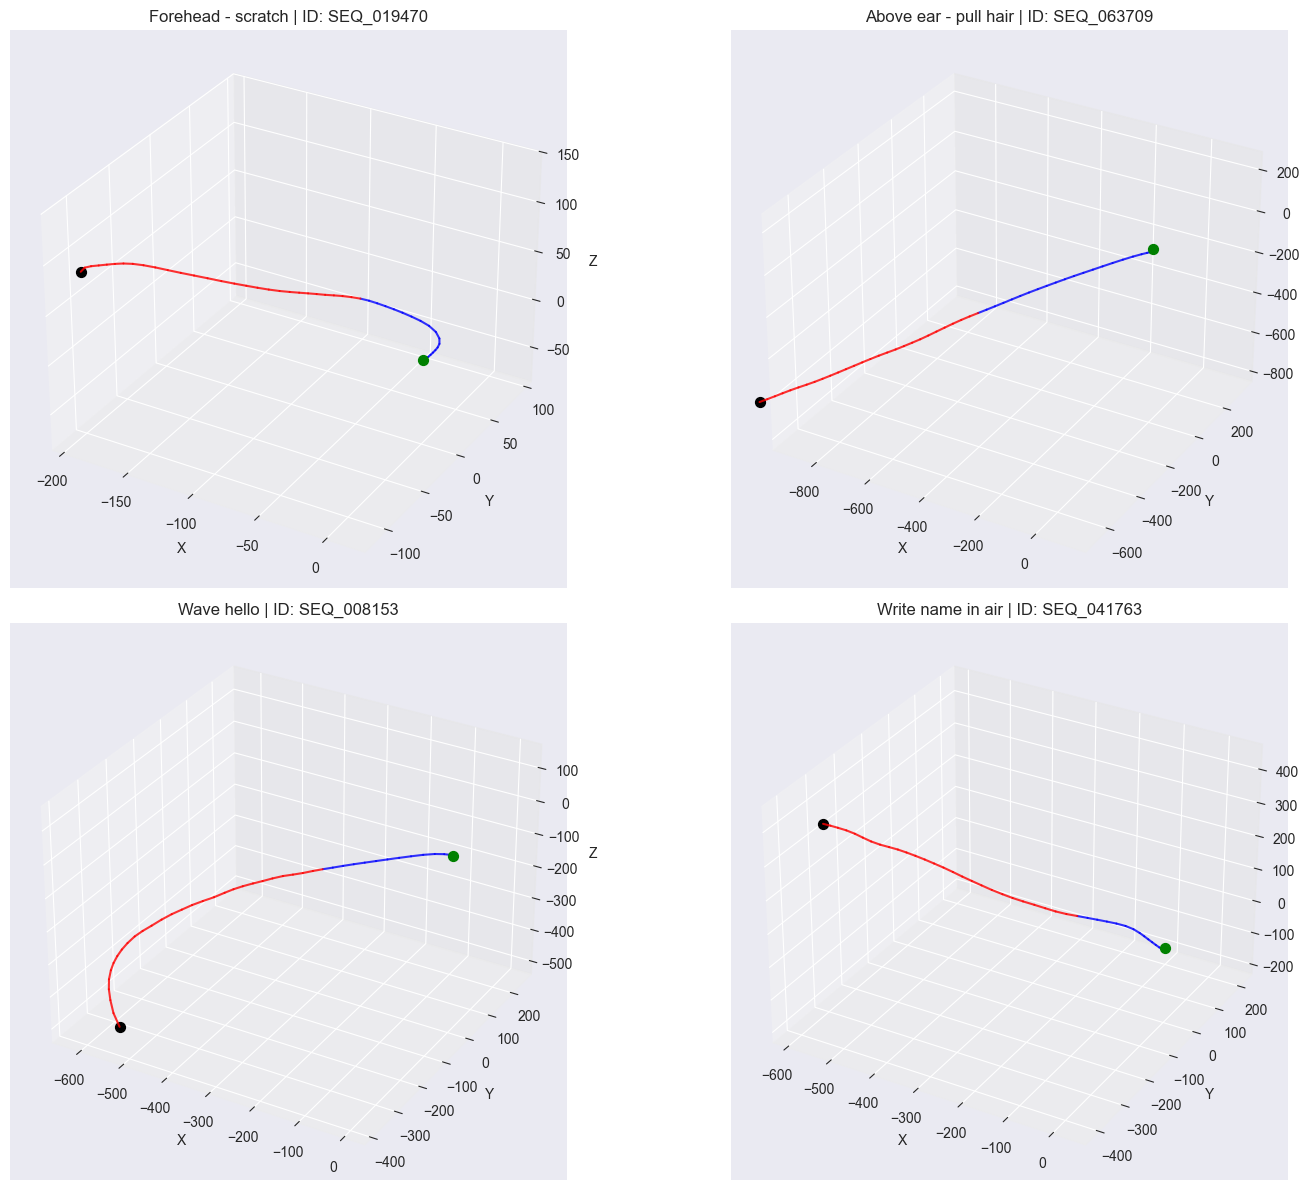

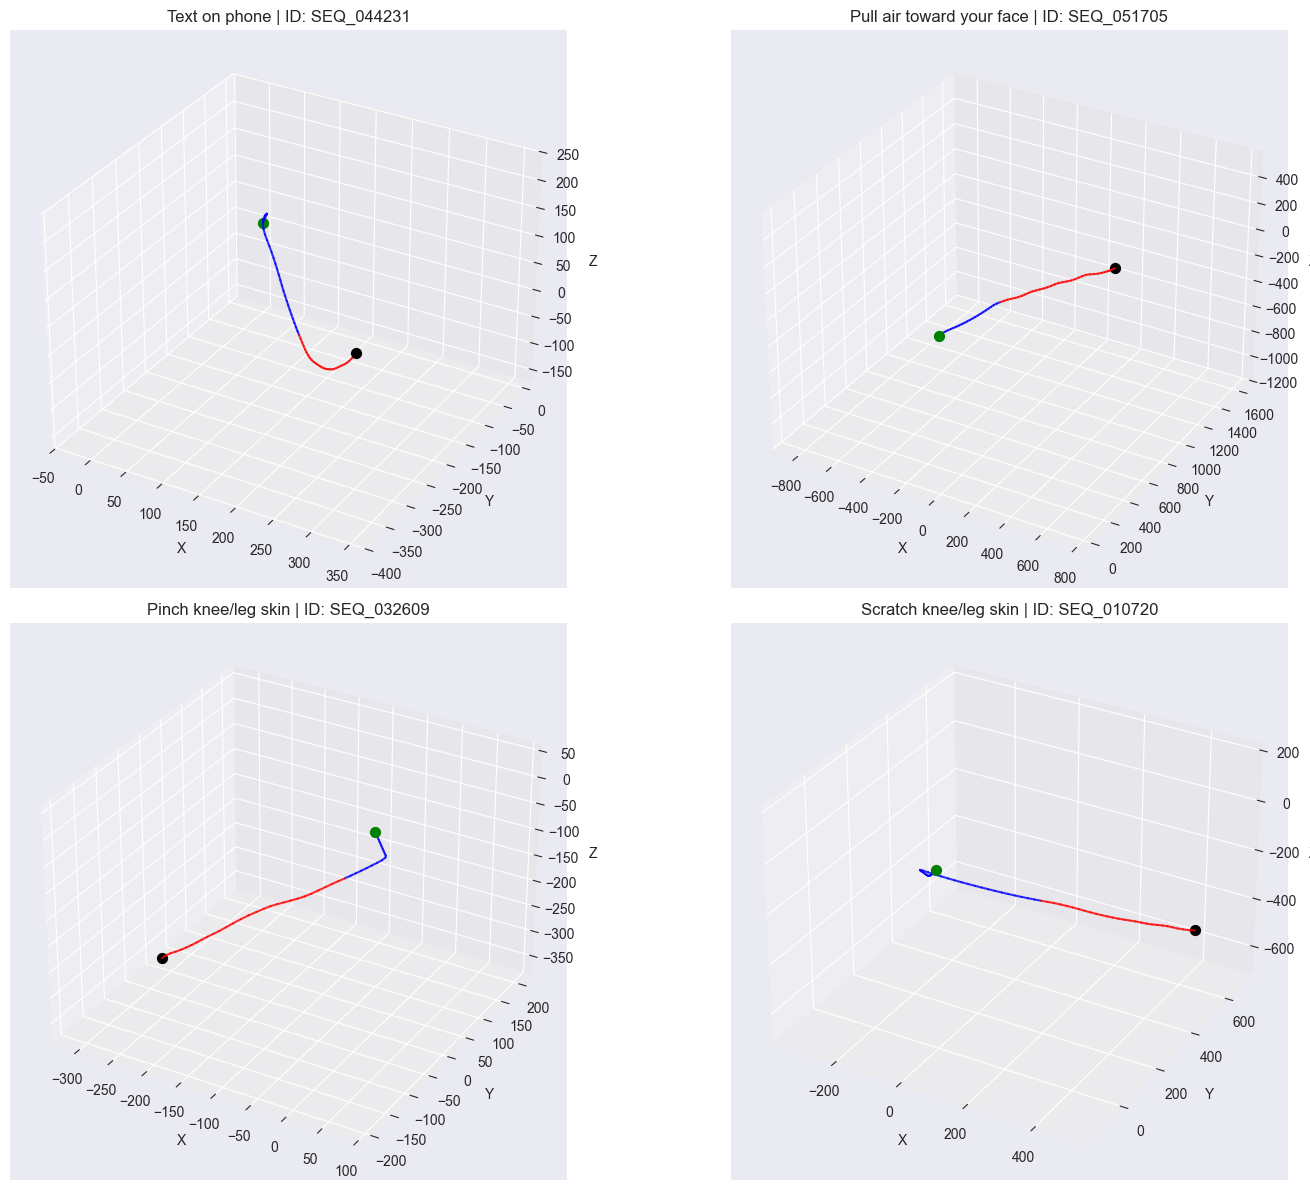

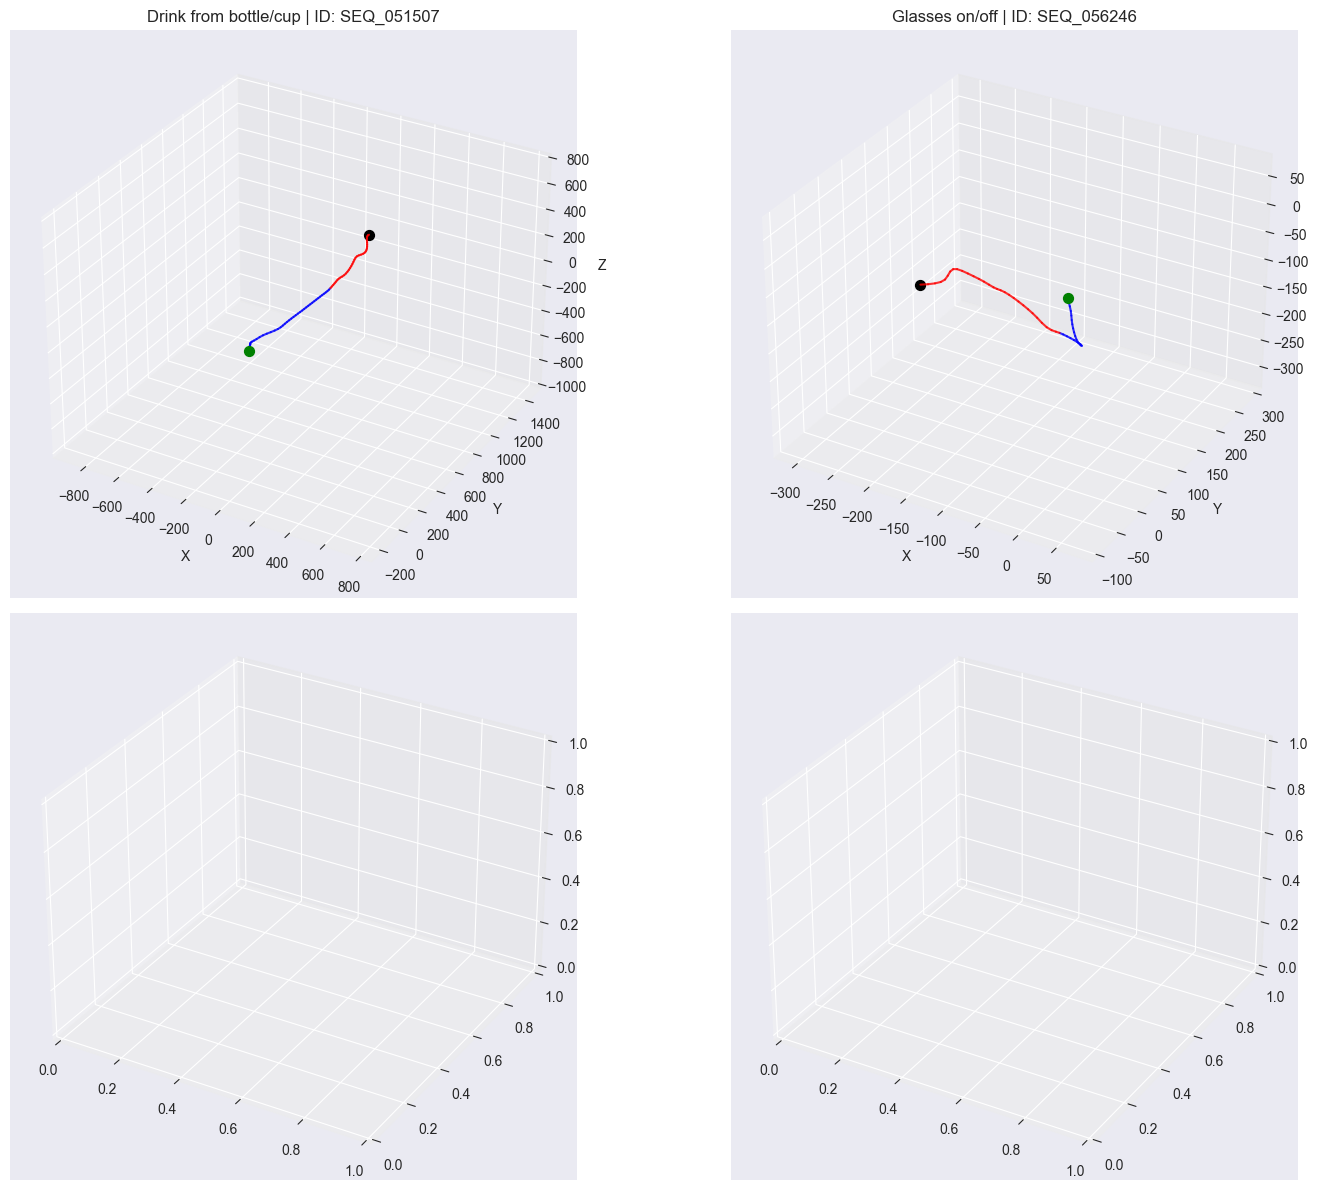

In [23]:
visualize_sample_gestures(train_df, 1)

The trajectory visualizations reveal significant inter-subject variability and noise in the double-integrated position estimates, making it challenging to identify clear per-gesture patterns visually. Drift accumulation from integration errors obscures true trajectories, and the wide range of starting positions/orientations further complicates pattern recognition. While trajectories show that gestures have different spatial extents (large movements for air gestures vs small movements for contact gestures), the high noise suggests that trajectory-based features may be less reliable than direct acceleration and rotation statistics. For the final project, we will focus on first-order (acceleration, angular velocity) and statistical features rather than integrated trajectories.

It is very hard to visually discern any clear pattern in the trajectory, regarding differences between target and non target gestures, as well as between gesture and non-gesture phases.
This issue  may be caused by **IMU Drift**, which is the accumulation of small errors in thea acclerometer readings over time. Visualizations that use double integration (Acceleration<--Velocity<--Location, like we did) are especially prone to IMU drift.

Additionally, we see a great variance between sequences in the length of each sequence and the lengths of gesture and non-gesture phases.

Let's try visualizing only the **accelerations** themselves to counteract the IMU drift and see if we can discern more meaningful paterns and anomalities.

---

Instead of relying on noisy integrated trajectories, we now visualize the acceleration vectors directly in world-frame coordinates after gravity compensation. These vector plots show the magnitude and direction of hand accelerations over time, providing a clearer view of motion dynamics without accumulation of integration errors. The acceleration patterns should more clearly distinguish high-motion gestures (waving, texting) from low-motion gestures (scratching, pinching).

We'll plot the acceleration vectors (in "North-up" rotation and after gravity is removed) as a time-series. We'll use the same color segmentation scheme between gesture and non-gesture phases.

Each gesture will present 2 sequences in hope of finding repeating behaviors

In [24]:
def plot_acceleration_vectors(processor: IMUProcessor, ax, title: str = "3D Acceleration Vectors", label_every: int = 1):
    """
    Renders 3D acceleration vectors with magnitude labels using Matplotlib.
    - label_every: Adds a text label every N points to prevent clutter.
    """
    acc = processor.acc_linear
    t_axis = processor.time_axis
    phases = processor.phases

    # Calculate total magnitude for each vector: sqrt(x^2 + y^2 + z^2)
    magnitudes = np.linalg.norm(acc, axis=1)

    # Removed creation of new figure and subplot, using the passed 'ax'

    def draw_vectors(mask, color, label):
        indices = np.where(mask)[0]
        segments = []
        for i in indices:
            start = [t_axis[i], 0, 0]
            # Vector represents full (x, y, z) linear acceleration
            end = [t_axis[i] + acc[i, 0], acc[i, 1], acc[i, 2]]
            segments.append([start, end])

            # Add magnitude label at the tip of the vector
            if i % label_every == 0:
                ax.text(end[0], end[1], end[2], f"{magnitudes[i]:.1f}",
                        color=color, fontsize=7, alpha=0.8)

        coll = Line3DCollection(segments, colors=color, linewidths=0.8, alpha=0.6, label=label)
        ax.add_collection3d(coll)

    if magnitudes.sum()>0:
      # Draw Gesture and Other phases
      draw_vectors(phases == 'Gesture', 'red', 'Gesture Accel')
      draw_vectors(phases != 'Gesture', 'blue', 'Other Accel')

      # Add the Timeline
      ax.plot(t_axis, np.zeros_like(t_axis), np.zeros_like(t_axis), color='black', linewidth=1, alpha=0.5)

      # Formatting
      # Parse the title to make the gesture part bold
      parts = title.split(' | ID: ', 1)
      if len(parts) == 2:
          gesture_name = parts[0]
          seq_id_part = parts[1]
          # Use Matplotlib's MathText for bolding with correct backslash escaping
          formatted_gesture_name = f"$\\mathbf{{{gesture_name}}}$"
          final_title = f"{formatted_gesture_name} | ID: {seq_id_part}\n(Labels: m/s²)"
          ax.set_title(final_title)
      else:
          # Fallback if the title format is unexpected
          ax.set_title(f"{title}\n(Labels: m/s²)")

      ax.set_xlabel('Time + Acc X')
      ax.set_ylabel('Acc Y')
      ax.set_zlabel('Acc Z')

      # Scaling
      ax.set_xlim(t_axis.min(), t_axis.max() + acc[:, 0].max())
      limit = np.abs(acc[:, 1:]).max() * 1.2
      ax.set_ylim(-limit, limit)
      ax.set_zlim(-limit, limit)

      ax.legend()
    else:
      ax.set_title(f"{title}\\nNo valid norms!")


In [25]:
def init_grid(fig=None, n_rows=1, n_cols=1):
    if fig:
        plt.tight_layout()
        plt.show()
        plt.close(fig)
    # Adjust figsize based on the number of rows and columns to make plots readable
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), subplot_kw={'projection': '3d'})
    # Ensure axes is always a 1D array of subplots for consistent indexing
    if n_rows == 1 and n_cols == 1:
        return fig, [axes] # Wrap single axis in a list
    else:
        return fig, axes.flatten()

def visualize_acc_gestures(train_df: pd.DataFrame, n_samples: int = 1, specific_sequences = None):
    """
    Visualizes acceleration vectors for selected sequences, arranged dynamically in grids.
    """
    unique_gestures = train_df["gesture"].unique()

    # If specific_sequences is provided as a list, convert to a set for efficient lookup
    if specific_sequences is not None:
        specific_sequences = set(specific_sequences)

    for gesture_type in unique_gestures:
        subset = train_df[train_df["gesture"] == gesture_type]
        available_ids = subset["sequence_id"].unique()

        # Filter selected_ids based on specific_sequences if provided
        if specific_sequences is not None:
            current_selected_ids = np.array(list(specific_sequences.intersection(available_ids)))
        else:
            # If no specific sequences, randomly sample n_samples
            actual_n = min(len(available_ids), n_samples)
            current_selected_ids = np.random.choice(available_ids, size=actual_n, replace=False)

        num_plots_for_gesture = len(current_selected_ids)

        if num_plots_for_gesture == 0:
            continue

        # Iterate through the sequences in chunks of 2
        for i in range(0, num_plots_for_gesture, 2):
            chunk_ids = current_selected_ids[i : i+2]
            num_plots_in_grid = len(chunk_ids)

            # Determine grid dimensions for the current chunk
            if num_plots_in_grid == 1:
                n_rows, n_cols = 1, 1 # Single plot
            else: # num_plots_in_grid == 2
                n_rows, n_cols = 1, 2 # Two plots in one row

            fig, axes = init_grid(None, n_rows=n_rows, n_cols=n_cols)

            # Dynamic suptitle based on whether it's the first part for this gesture
            if i == 0:
                fig.suptitle(f"{gesture_type}", fontweight='bold', fontsize=16)

            for plot_idx_in_grid, seq_id in enumerate(chunk_ids):
                current_ax = axes[plot_idx_in_grid]

                seq_imu_df = subset[subset["sequence_id"] == seq_id]

                proc = IMUProcessor(seq_imu_df)
                if proc.acc_linear is not None:
                    plot_acceleration_vectors(proc, current_ax, title=f"ID: {seq_id}")
                else:
                    current_ax.set_title(f"ID: {seq_id}\nNo valid IMU data")
                    # Ensure the plot remains functional even with no data
                    current_ax.text(0.5, 0.5, 0.5, "No IMU Data", transform=current_ax.transAxes, ha='center', va='center')
                    current_ax.set_xlabel('X'); current_ax.set_ylabel('Y'); current_ax.set_zlabel('Z') # Ensure labels are set

            plt.tight_layout()
            plt.show()
            plt.close(fig) # Close the figure immediately after displaying it.

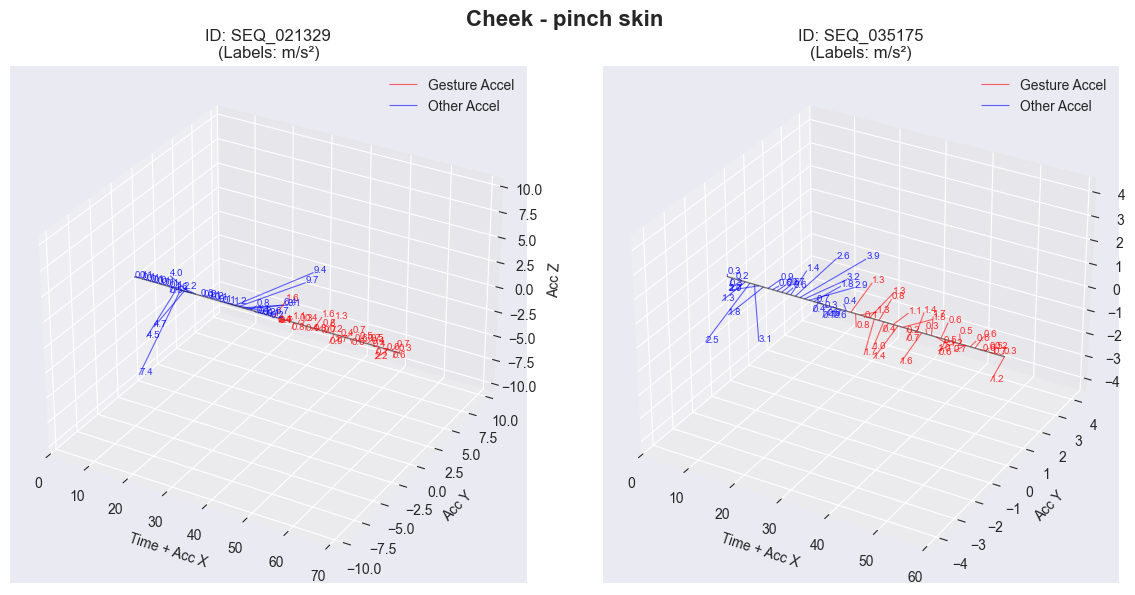

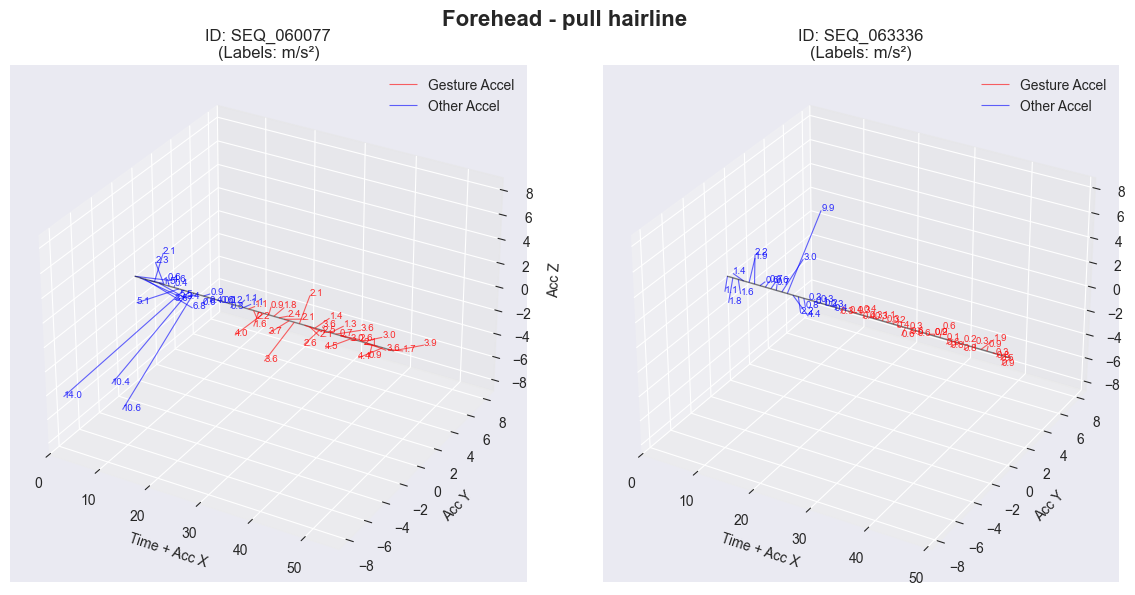

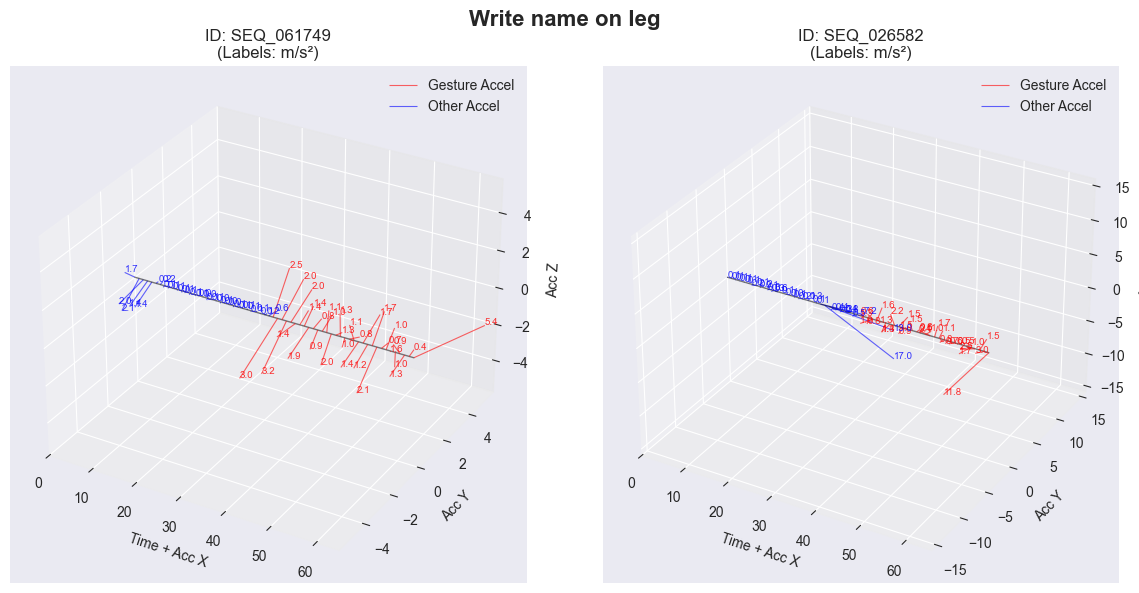

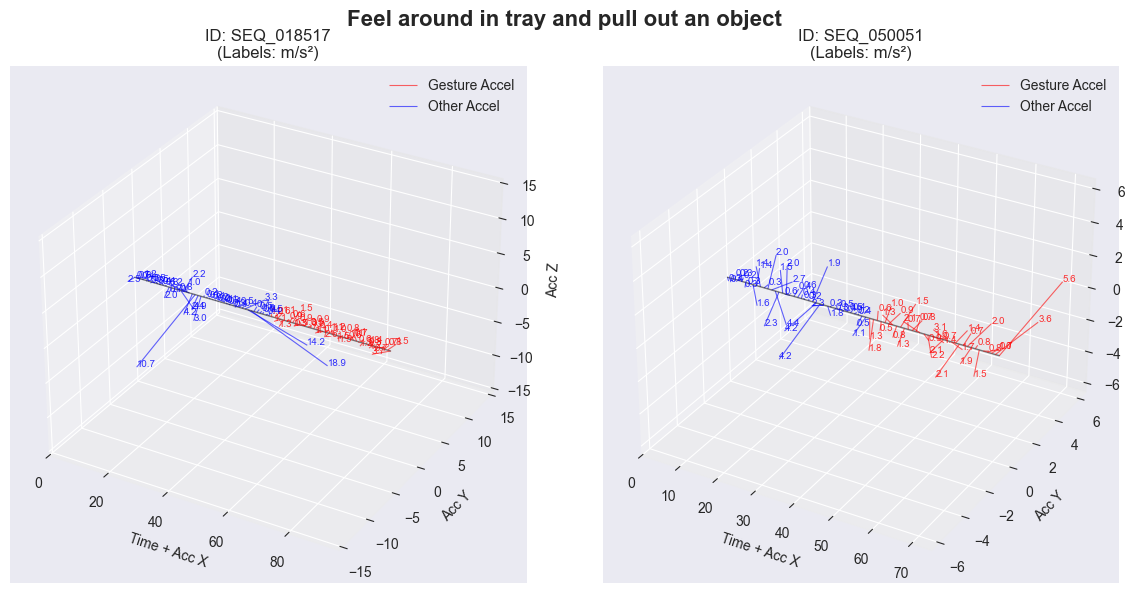

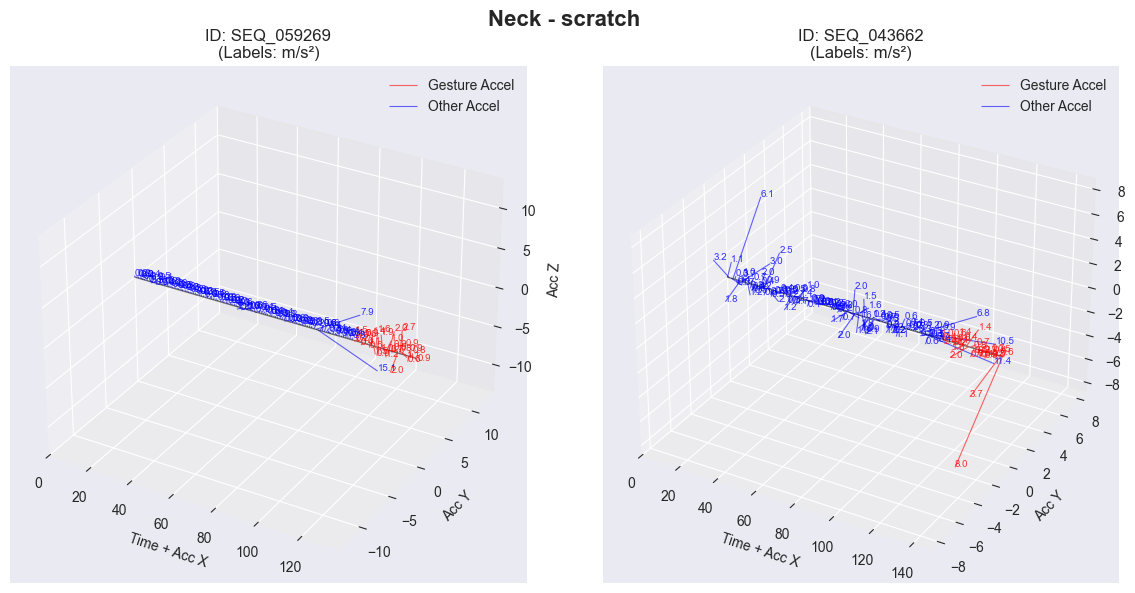

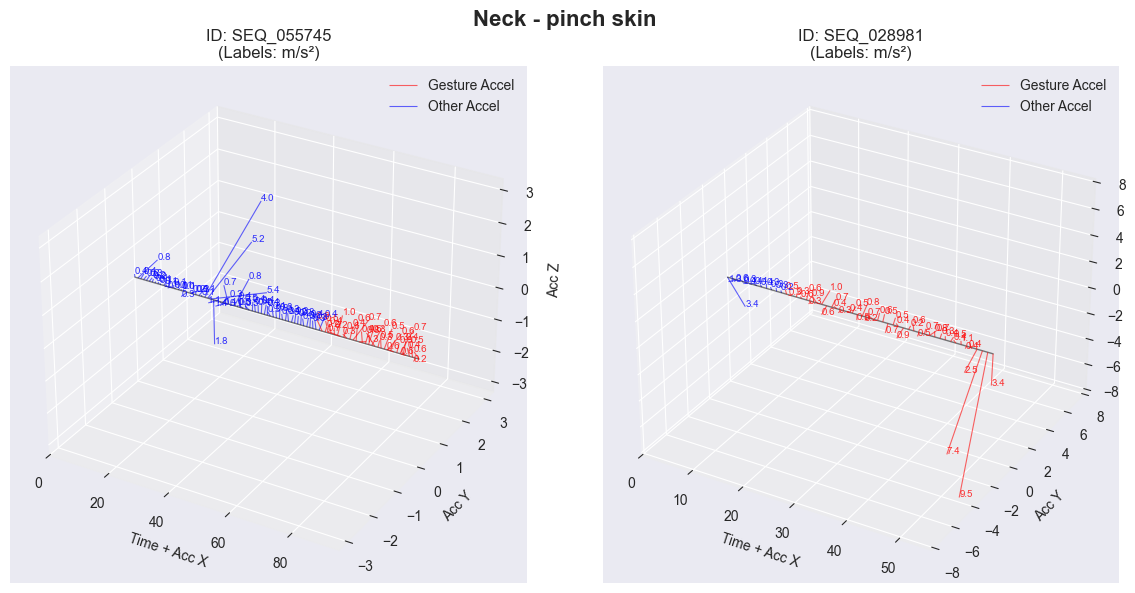

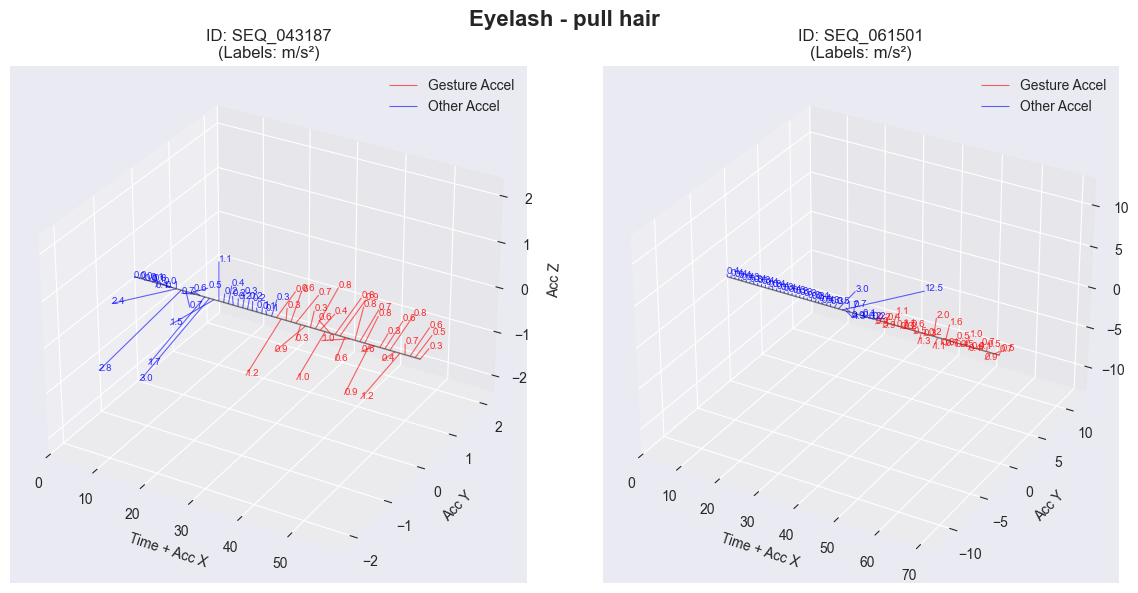

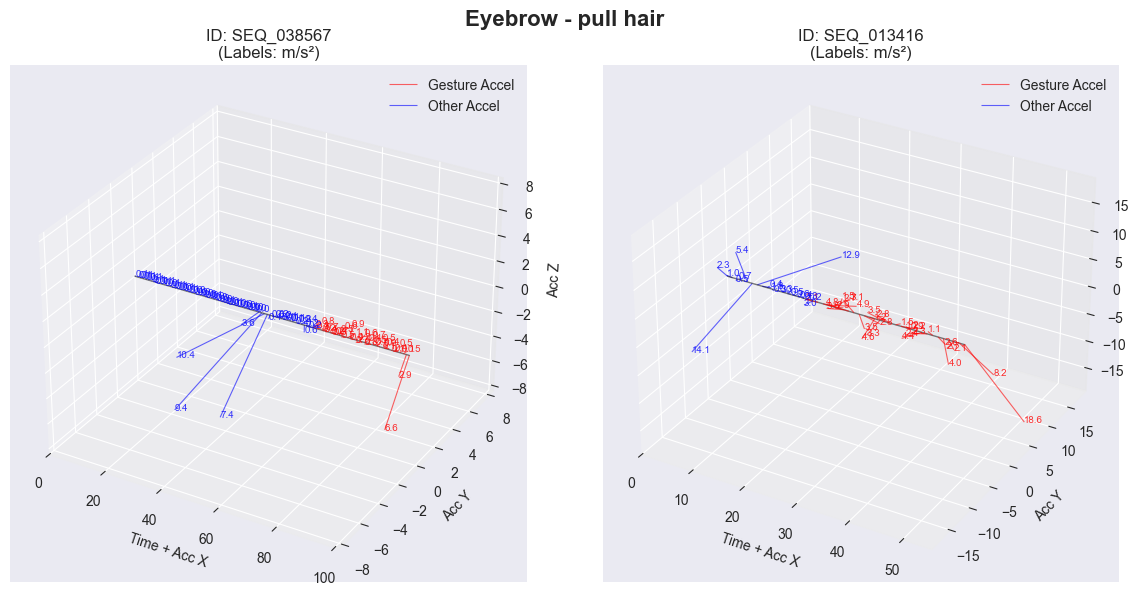

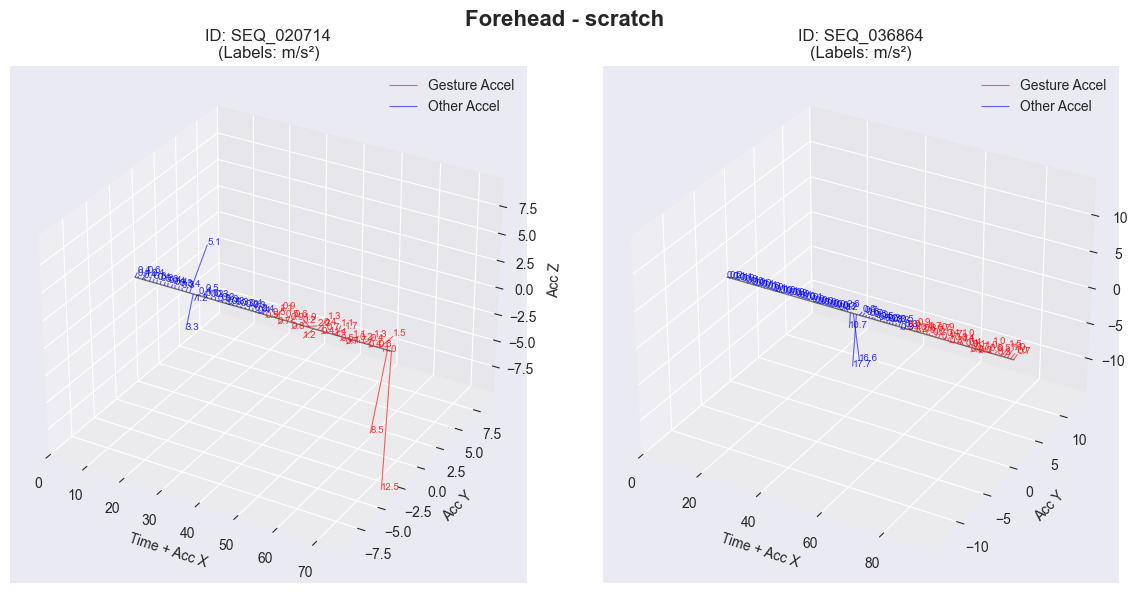

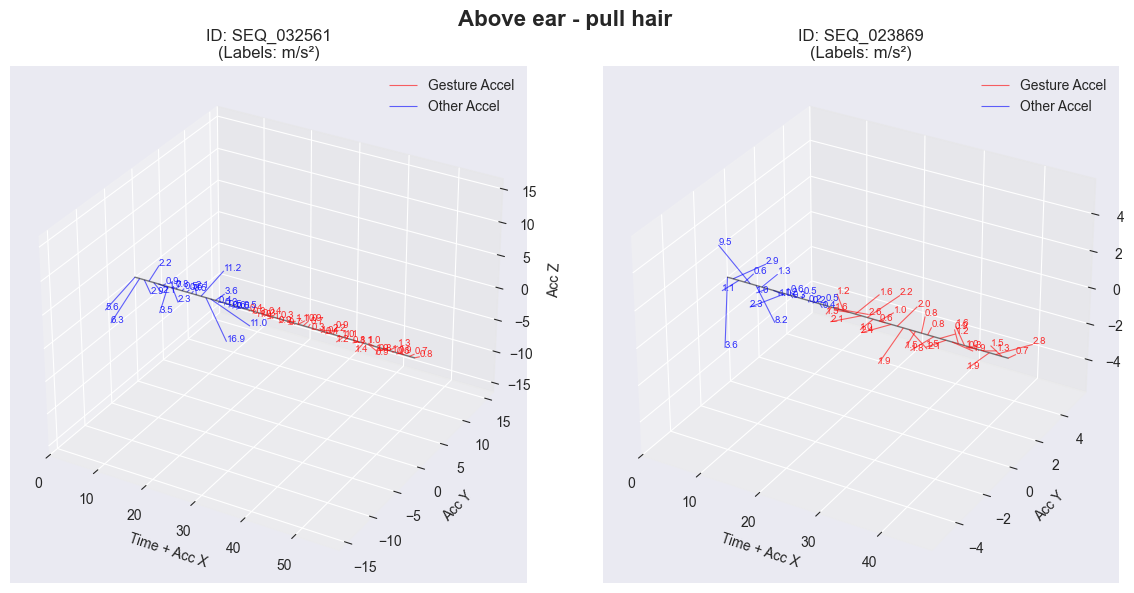

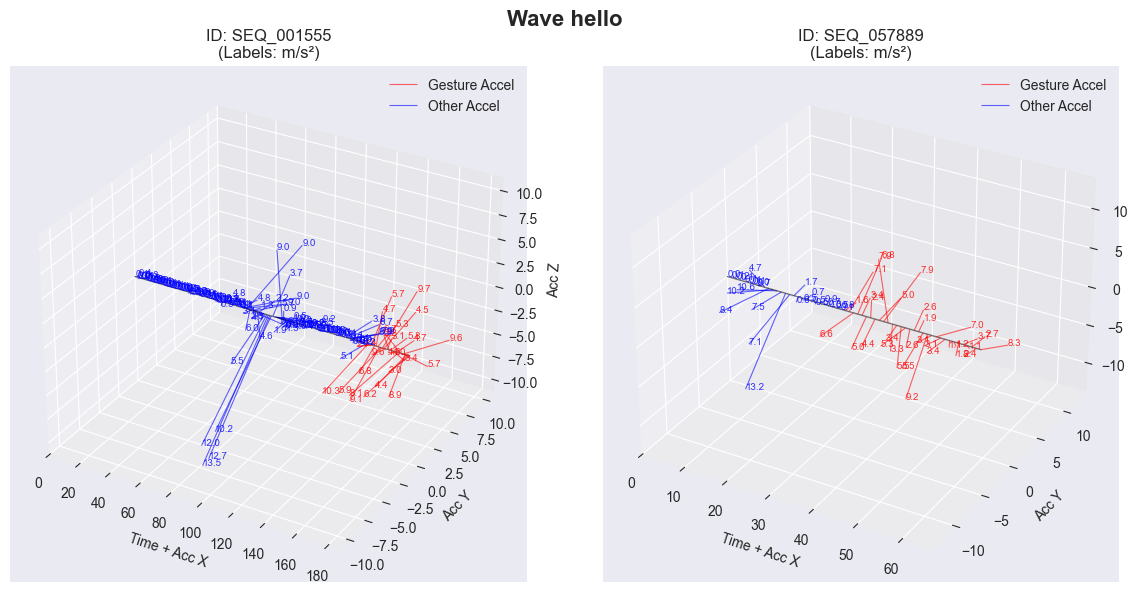

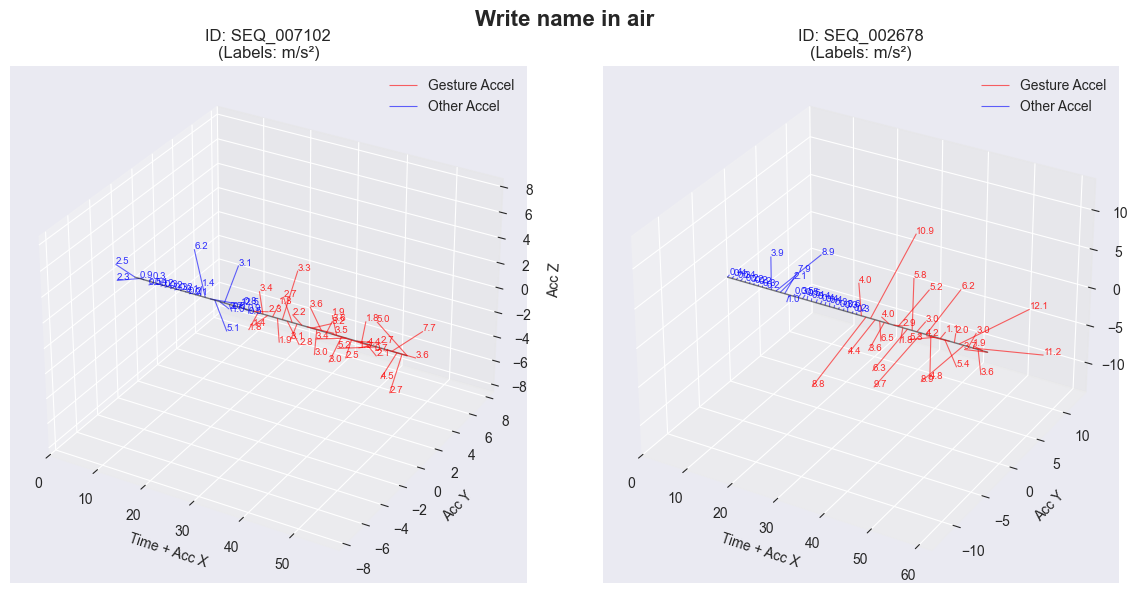

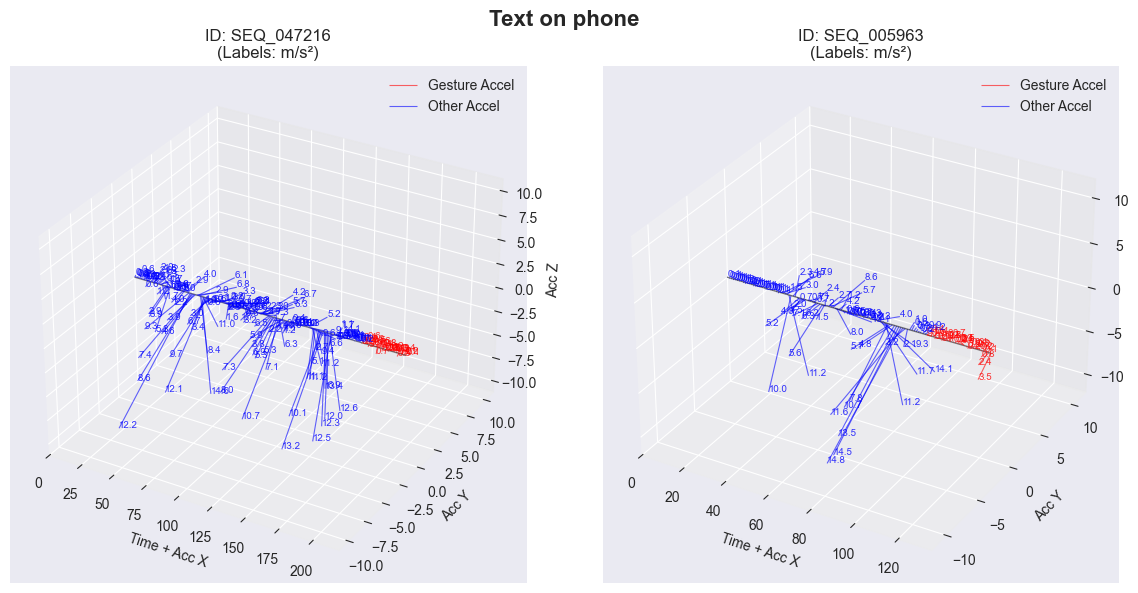

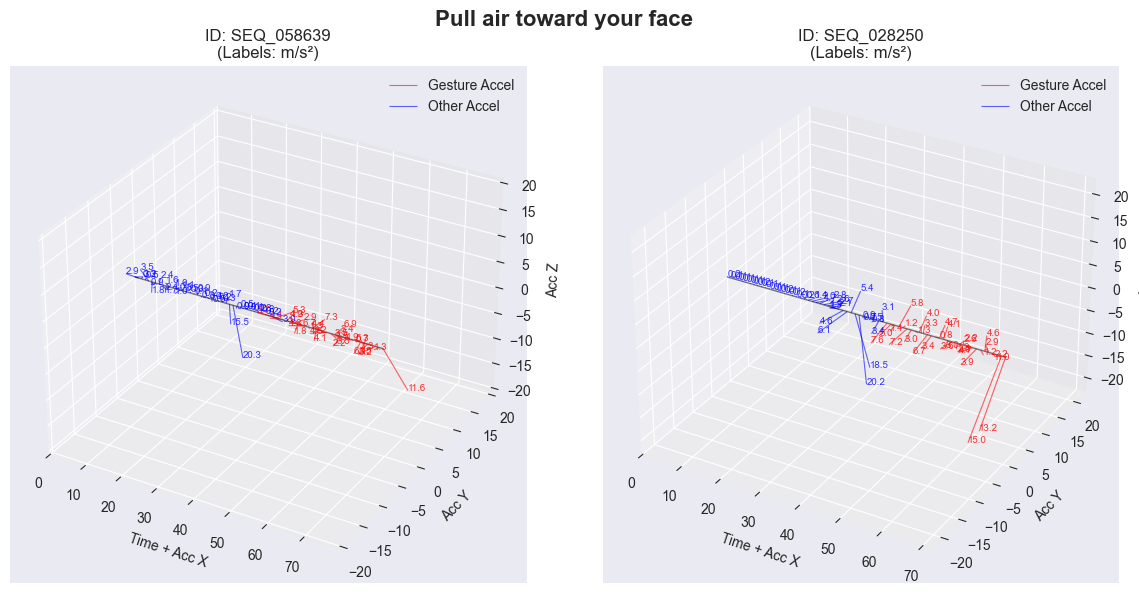

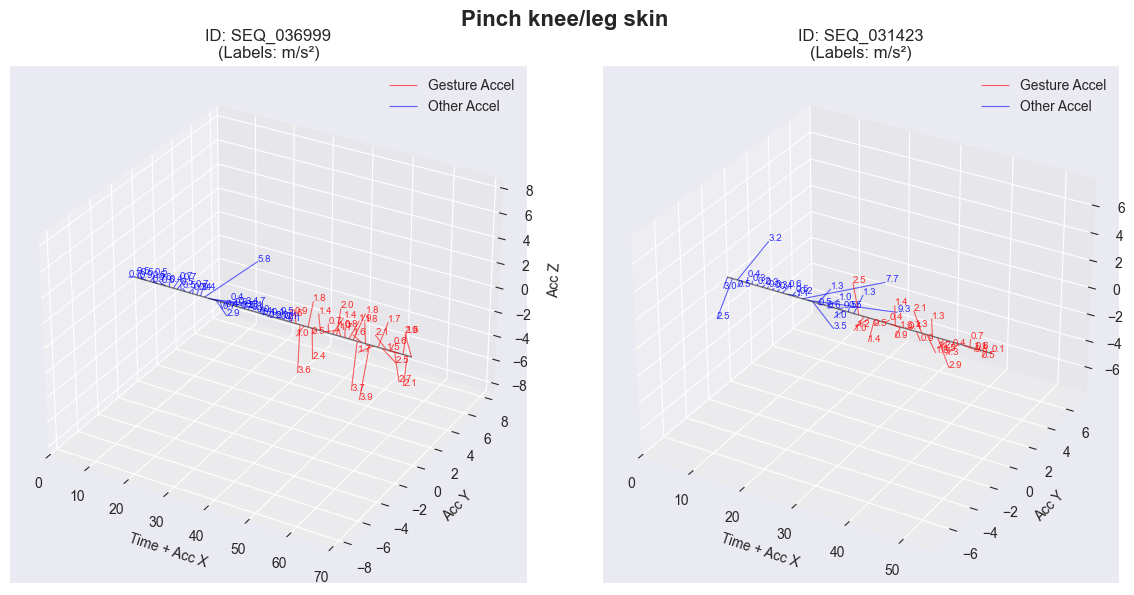

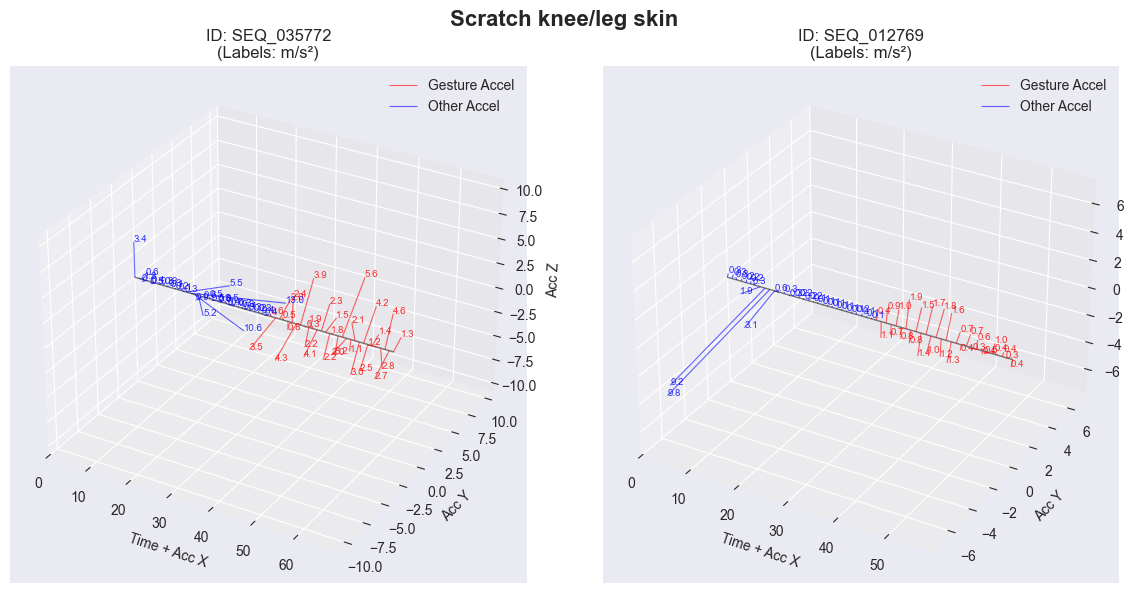

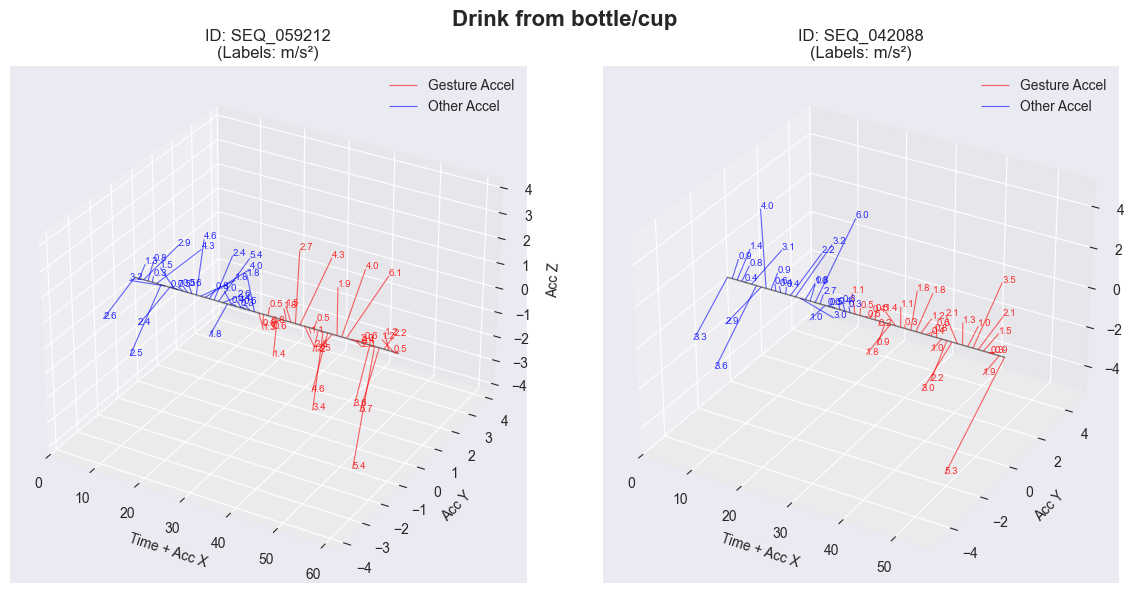

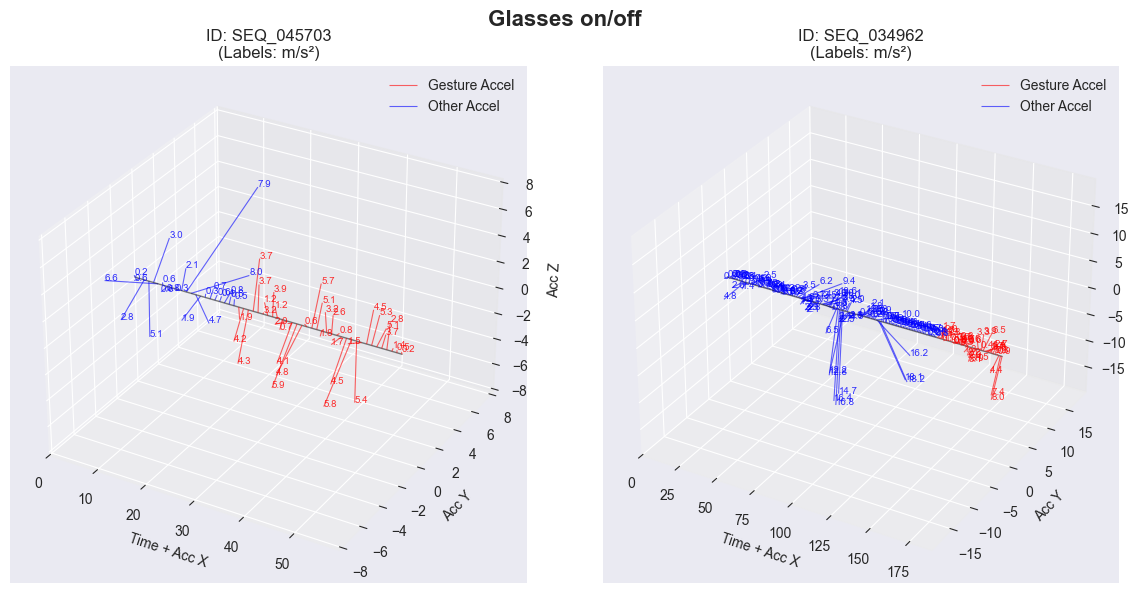

In [26]:
visualize_acc_gestures(train_df, 2)

We'll select visually distinct sequences for further statistical anaylsis:

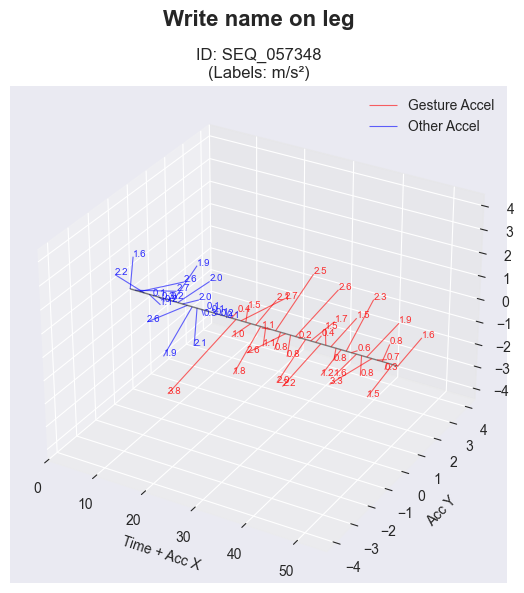

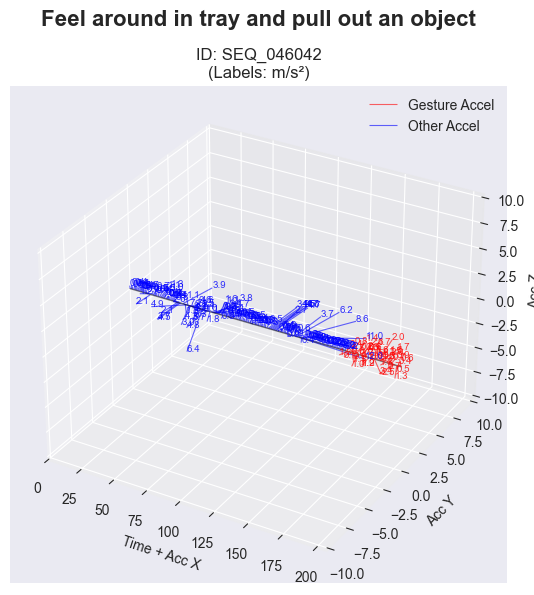

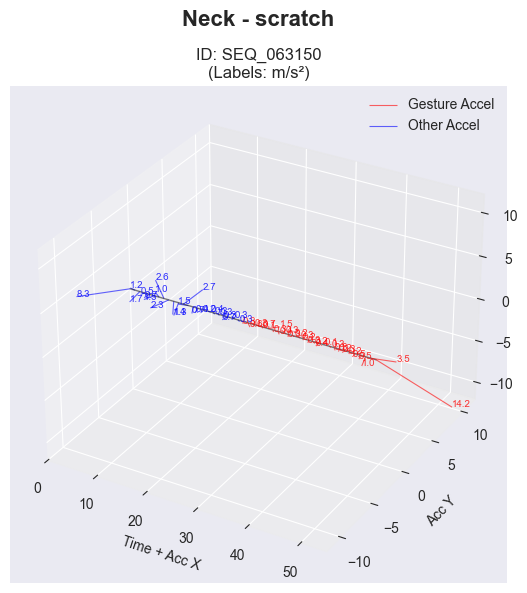

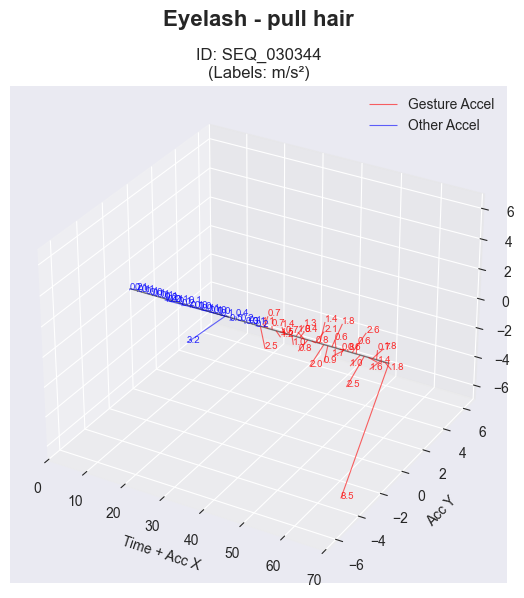

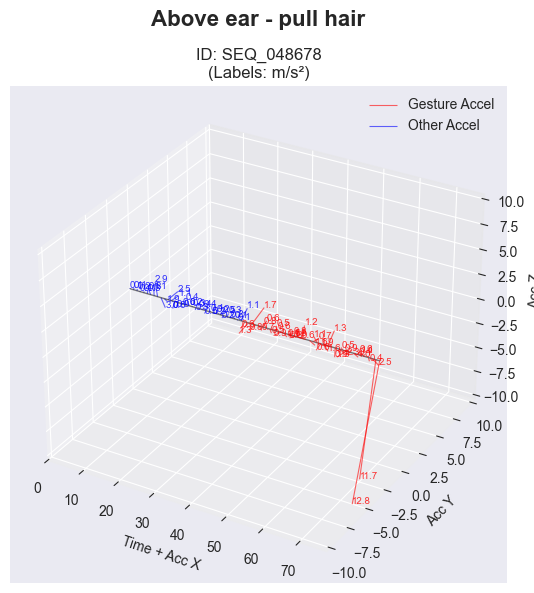

In [27]:
interesting_seqs = ["SEQ_048678", "SEQ_030344", "SEQ_046042", "SEQ_057348", "SEQ_063150"]
visualize_acc_gestures(train_df, 2, interesting_seqs)

#### Conclusions

The acceleration vector visualizations clearly show that different gesture types exhibit distinct motion patterns. High-motion gestures (wave, text on phone) display frequent, large-magnitude acceleration spikes, while contact gestures (scratch, pinch) show primarily low-magnitude, localized movements with occasional spikes during contact initiation/termination. Outlier accelerations are readily visible and could indicate gesture transition points or specific gesture characteristics (e.g., the "snap" motion when pulling hair). These observations validate that acceleration-based features (magnitude, variance, peak detection) will be highly discriminative for classification. The temporal structure of accelerations (rhythm, frequency of peaks) may also encode gesture-specific signatures.

When we plot the acceleration vectors, we can clearly see acceleration outliers in each sequence:
- The last two vectors in Seq. 048678 have an acceleration value of
11.5-12.8, while the next largest acceleration value is 1.7
- The last vector in Seq. 030344 has an acceleration value of 8.5, while the next largest acceleration value is 3.2 and not in the "gesture" phase

Additionally, we can also see outliers in the length of each phase type:
- In Seq. 046042, there are 204 data points, while in Seq. 063150 there are 50 data points.
- In Seq. 046042 there are 40 "Gesture" phase datapoints and 164 non-gesture phase datapoints, while in Seq. 057348 there are 34 "Gesture" datapoints, compared to 21  non-gesture phase datapoints.

#### Summary

Through systematic visualization of IMU data (quaternions, accelerations, trajectories), we've established that **acceleration-based features are more reliable than trajectory-based features** due to integration error accumulation. Direct measurements (acceleration magnitude, angular velocity) provide cleaner signals that clearly differentiate high-motion from low-motion gestures. Key insights for feature engineering: (1) use first-order derivatives (acceleration, jerk) rather than integrated positions, (2) compute statistics over the gesture phase only, excluding transitions, (3) leverage temporal patterns (autocorrelation, peak frequency) in addition to magnitude statistics, and (4) rotation angles (roll, pitch, yaw) provide complementary information about hand orientation that distinguishes similar gestures.

We managed to represent the accelerometer data as "meaningful" visualizations, especially when visualizing the raw acceleration values as vectors. For further EDA, we'll use statistical calculations on the entire dataset, to see if we can identify any outliers and trends.

### Statistical Analysis

Beyond visualization, we now turn to quantitative statistical analysis of the accelerometer data. Statistical features (mean, variance, percentiles, trends) will form the foundation of our machine learning models, as they capture gesture characteristics in a compact, noise-robust manner. The following analyses explore rest vs active phases, sequence-level statistics, and identification of corrupted sensor data that may need special handling.

We have seen that we can derive meaningful representations of the Accelerometer data using visualization techniques. To get meaningful conclusions from the data at scale, we will use statistical analysis tools and methodologies.

#### Identifying rest data

Distinguishing between rest (no movement) and active gesture phases is critical for robust feature extraction. Rest periods exhibit low acceleration variance (primarily sensor noise around 0 m/s²), while active gesture phases show elevated acceleration magnitudes and variance. We use a sliding window variance threshold to automatically segment sequences into rest vs active periods, which allows us to: (1) exclude rest phases when computing gesture statistics, (2) identify gesture onset/offset times, and (3) engineer features like "% of sequence spent in motion" that capture gesture dynamics. This segmentation improves feature quality by focusing on informative signal rather than noisy rest periods.

To identify "meaningful" sequences, we first need to determine the "unmeaningful" data. we want sequences which have some movement in them, which isn't a simple "resting" movement. We'll use a Rolling Variance (or Rolling Standard Deviation) of the signal magnitude as a meter for "rest" periods.

We'll use a sliding window approach with window size=10 (~0.5 seconds). We expect the variance inside the window within the rest phase to be lower than the variance within the window outside the rest phase.

This will give us a way to clean out any sequences that have only rest phases.

Since we are calculating the variance, we won't need to normalize using quaternions, and will run on the raw acceleration values (including gravity).

In [28]:
def estimate_and_find_rest(df, threshold_multiplier=1.5):
    """
    df: DataFrame with columns ['x', 'y', 'z']
    threshold_multiplier: sensitivity for rest detection
    """

    # 1. Calculate Vector Magnitude (Resultant Acceleration)
    # This removes the effect of sensor orientation
    df['mag'] = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)

    # 2. Heuristic Sample Rate Estimation
    # We look for the first significant peak in autocorrelation of the
    # 'movement' part of the signal. If we assume a fast wrist tap
    # or writing stroke is ~0.2 seconds:
    autocorr = np.correlate(df['mag'] - df['mag'].mean(),
                            df['mag'] - df['mag'].mean(), mode='full')
    # Use a safe default if estimation is too noisy
    estimated_fs = 15

    # 3. Sliding Window Variance
    # window_size: 1 second of data is usually best for 'rest' detection
    window_size = 15
    df['rolling_var'] = df['mag'].rolling(window=window_size, center=True).var()

    # 4. Define 'Rest' Threshold
    # We find the 'quietest' part of the signal and use its noise level
    noise_floor = df['rolling_var'].quantile(0.1) # 10th percentile is usually noise
    rest_threshold = noise_floor * threshold_multiplier

    # 5. Label Rest vs Action
    # 1 for Rest, 0 for Movement
    df['is_rest'] = (df['rolling_var'] < rest_threshold).astype(int)

    # Clean up short 'flickers' (a rest must last at least 0.5 seconds)
    min_rest_samples = int(estimated_fs * 0.5)
    df['is_rest'] = df['is_rest'].rolling(window=min_rest_samples, center=True).median().fillna(0)

    return df, estimated_fs, rest_threshold

In [29]:
df_processed, fs, thresh = estimate_and_find_rest(train_df[["acc_x", "acc_y", "acc_z"]])
print(f"Calculated Rest Threshold: {thresh:.6f}")

Calculated Rest Threshold: 0.007875


We'll try to find sequences where the variation of the norm is below the threshold. These sequences do not have any information and we'll assume that they are falsely labeled.

In [30]:
train_df["acc_norms"] = np.linalg.norm(train_df[['acc_x', 'acc_y', 'acc_z']].values, axis=1)

In [31]:
valid_sequences_mask = train_df.groupby(["sequence_id"])["acc_norms"].var() < thresh

In [32]:
pd.Series(train_df["sequence_id"].unique())[valid_sequences_mask.values]

4540    SEQ_036615
dtype: object

Let's visualize acceleration values of the sequence

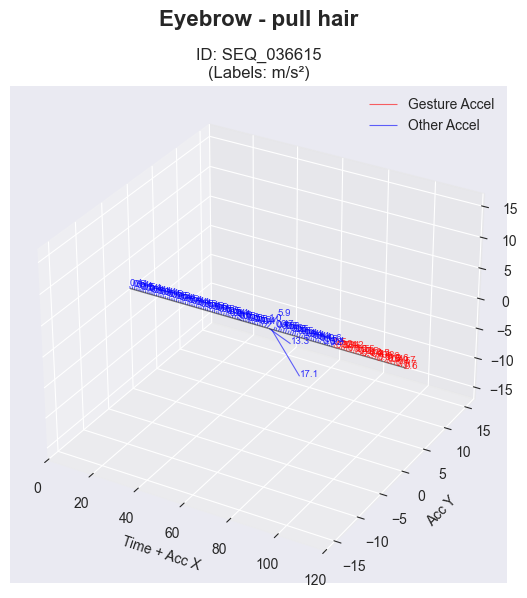

In [33]:
visualize_acc_gestures(train_df, 1, ["SEQ_036615"])

We can clearly see that there is almost no motion in the "gesture" phase.

We'll continue to analyze the variance in acceleration magnitute using a sliding window for all other "Gesture" phases in the sequences. We'll try to determine which gestures have the lowest acceleration magnitude variance. These gestures will be the hardest to tell apart. For each sequence, we'll calculate a "score" of gesture phase variance:

We'll calculate a sliding window variance for the gesture phase. Then, we'll count the values who are below the threshold. We'll divide the count of values below the threshold by the length of the gesture phase to get the "score" of each sequence's "gesture" phase. When the score is close to 1, almost all the "gesture" phase's variance by windows is below the threshold.

We'll visualize the sequences with 10 highest scores.

In [34]:
def divide(tup):
  return tup[0]/tup[1]

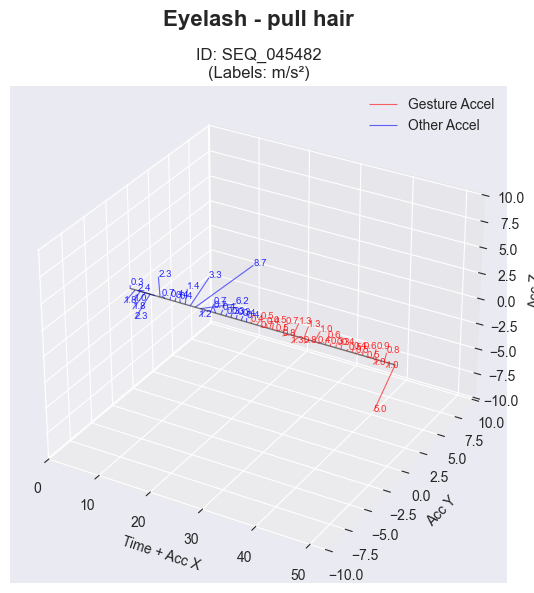

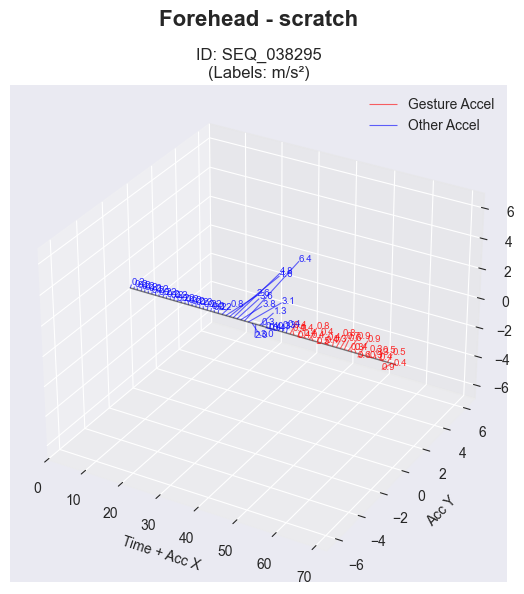

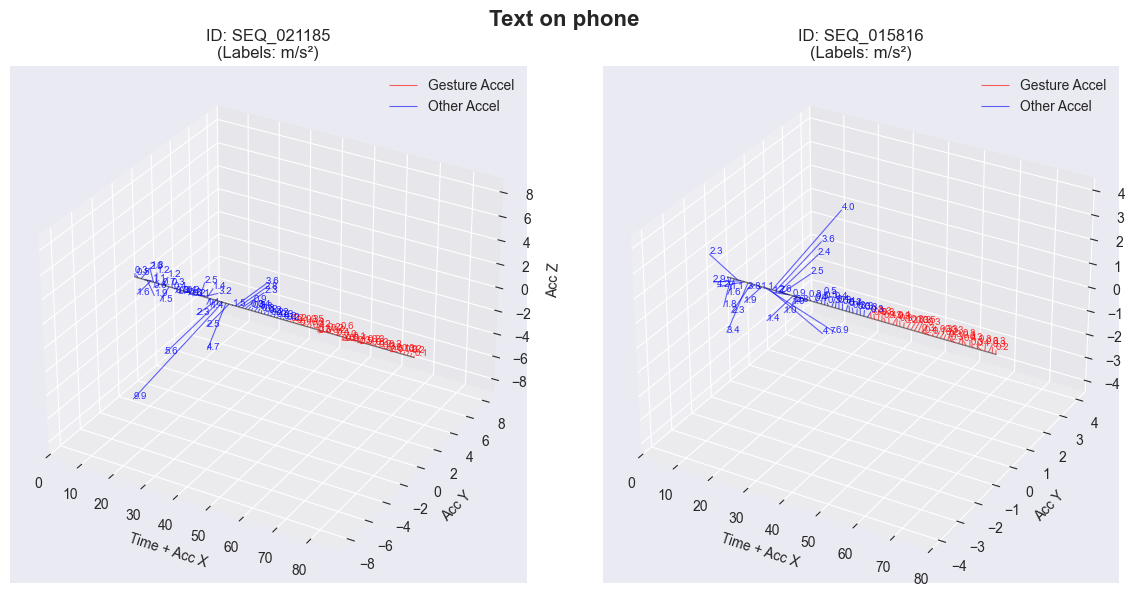

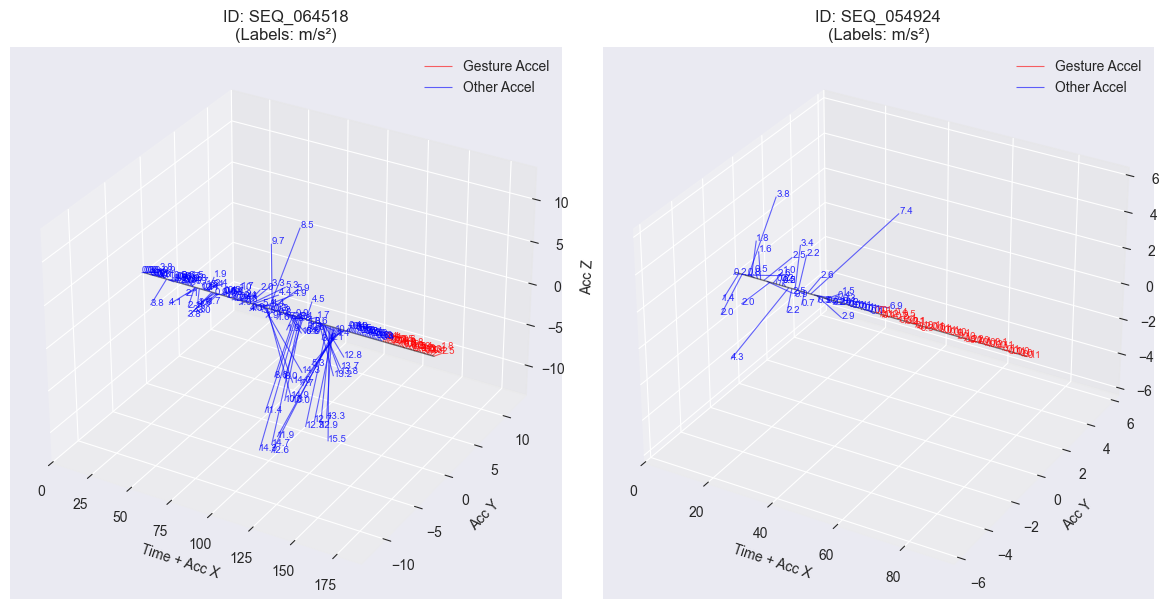

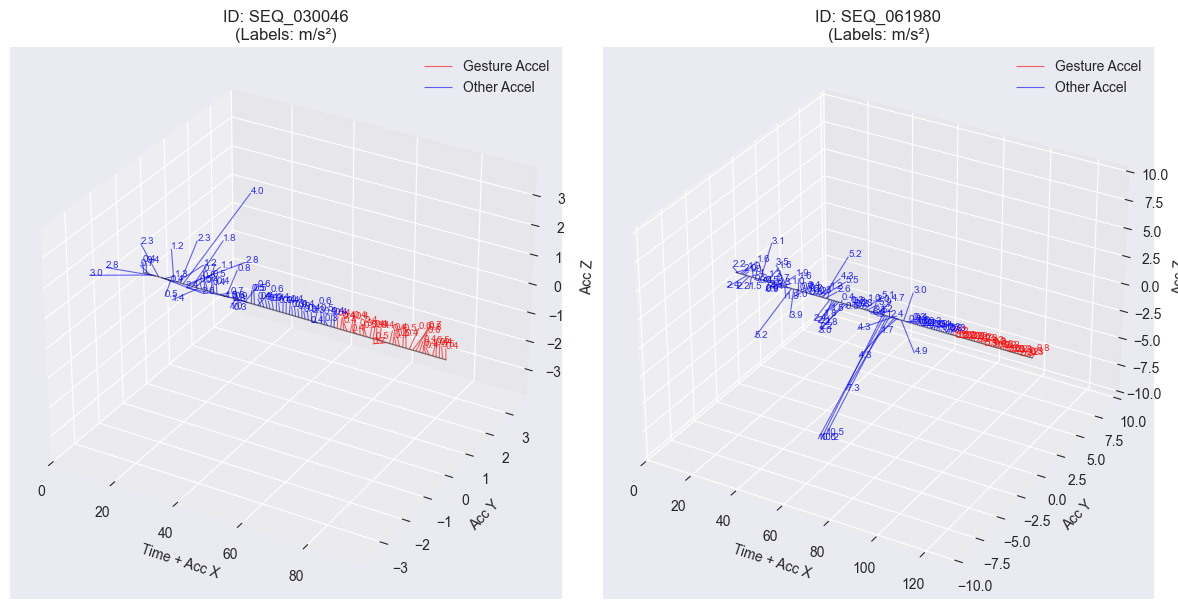

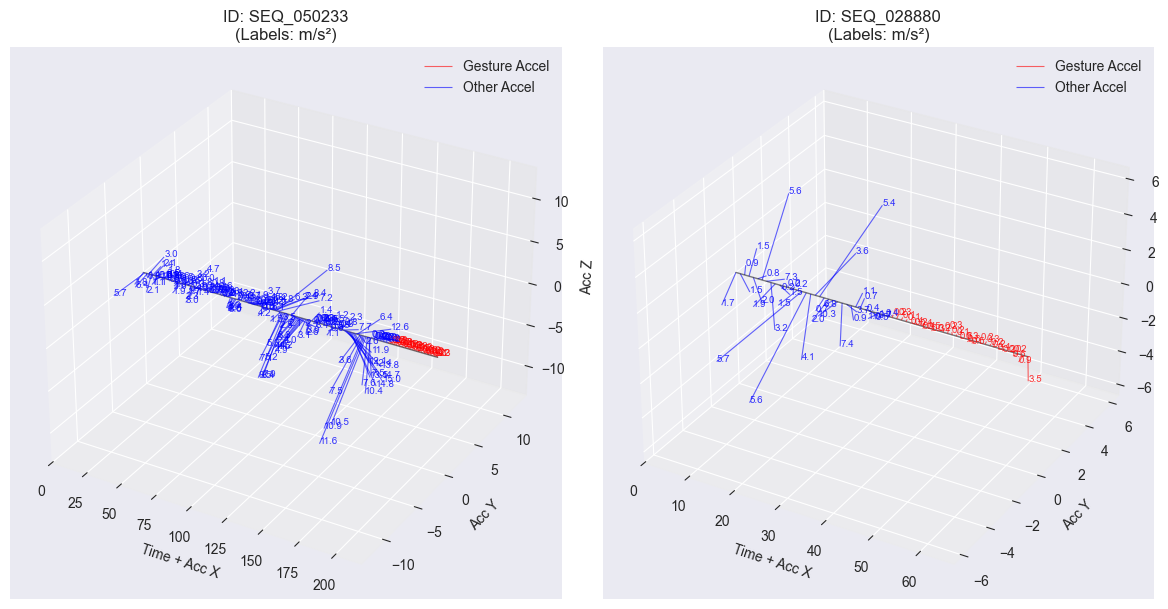

In [37]:
rolling_window_norm_var_df = pd.DataFrame(
    train_df[train_df["phase"]=="Gesture"].groupby(["sequence_id"])["acc_norms"].rolling(window=15, min_periods=1).var()
    ).fillna(0)
roll_win_var_below_thresh_mask = rolling_window_norm_var_df["acc_norms"]<thresh
lowest_var_sequences = pd.merge(left = rolling_window_norm_var_df[
    roll_win_var_below_thresh_mask].groupby("sequence_id").count(),
         right = train_df[train_df["phase"]=="Gesture"].groupby(["sequence_id"]).count(),
         how="left", on="sequence_id").agg(func=divide, axis=1).sort_values(ascending=False)
visualize_acc_gestures(train_df, 1, lowest_var_sequences[:10].index)


We can visually see that the gestures with lowest variance score seemt to have a very similar "gesture" phase, with almost no variation in accuracy.

We'll sum the "score" values of all the sequences in a single Gesture type to get the Gesture score. If the score is high-it means that the sliding window variance of the "gesture" phase is very low. We'll hypothesize that it will be very hard to tell apart Gestures with very high Gesture scores.

We'll calculate the gesture scores over all the dataset, and counteract the Gesture class imbalance by multiplying under-represented Gesture scores by a value bigger than 1 to match their under-represented prevalence in the dataset.

We'll see which Gestures have the highest scores - and hypothesize that these will be the ones which we will have the hardest time to tell apart.

In [38]:
lowest_var_sequences = pd.DataFrame(lowest_var_sequences)

In [39]:
lowest_var_sequences = pd.merge(left=lowest_var_sequences,
                                right=train_df[["sequence_id", "gesture", "subject"]].drop_duplicates(),
                                how="left", on="sequence_id")
lowest_var_sequences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8150 entries, 0 to 8149
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sequence_id  8150 non-null   object 
 1   0            8150 non-null   float64
 2   gesture      8150 non-null   object 
 3   subject      8150 non-null   object 
dtypes: float64(1), object(3)
memory usage: 254.8+ KB


Let's focus on the Gestures that have all their variance windows below the threshold.

In [40]:
lowest_var_sequences[lowest_var_sequences[0]==1.0].sort_values(by="subject")

sequence_id    0              gesture      subject
20  SEQ_058214  1.0        Text on phone  SUBJ_008304
13  SEQ_019813  1.0        Text on phone  SUBJ_008728
14  SEQ_035699  1.0        Text on phone  SUBJ_011323
17  SEQ_014803  1.0  Eyelash - pull hair  SUBJ_019756
11  SEQ_048229  1.0        Text on phone  SUBJ_020948
18  SEQ_029259  1.0        Text on phone  SUBJ_024825
5   SEQ_028880  1.0        Text on phone  SUBJ_026824
3   SEQ_045482  1.0  Eyelash - pull hair  SUBJ_030676
1   SEQ_050233  1.0        Text on phone  SUBJ_032165
0   SEQ_054924  1.0        Text on phone  SUBJ_032585
12  SEQ_057102  1.0  Eyelash - pull hair  SUBJ_039498
19  SEQ_019131  1.0   Cheek - pinch skin  SUBJ_040724
6   SEQ_030046  1.0        Text on phone  SUBJ_051942
4   SEQ_015816  1.0        Text on phone  SUBJ_053173
8   SEQ_038295  1.0   Forehead - scratch  SUBJ_053906
21  SEQ_044398  1.0        Text on phone  SUBJ_055211
16  SEQ_017203  1.0        Text on phone  SUBJ_056936
15  SEQ_022281  1.0        Text on phone  SUBJ_056936
10  SEQ_059826  1.0    Neck - pinch skin  SUBJ_056936
7   SEQ_021185  1.0        Text on phone  SUBJ_058967
9   SEQ_061980  1.0        Text on phone  SUBJ_063464
2   SEQ_064518  1.0        Text on phone  SUBJ_063464

we see that most ofthe values are attributed to one type of behaviour - "Text on phone". We do not see a specific subject who appears many times (the only one that appears more than twice is SUBJ_056936 which appears 3 times, only one other subject appears twice, the others only once). Let's see if the gesture "Text on phone" is globally with a low score in terms of gesture-phase variance.
We'll normalize by the inverse prevalence of the gesture in the dataset to counteract label imbalance

In [41]:
a = pd.DataFrame(train_df.groupby("gesture")["sequence_id"].unique())
a["amounts"] = np.array([len(train_df.groupby("gesture")["sequence_id"].unique()[i]) for i in range(len(train_df["gesture"].unique()))])
m = a["amounts"].max()
a["amounts"] = m / a["amounts"]
d1 = {gesture: prev for gesture, prev in a["amounts"].items()}


In [42]:
gest_score = lowest_var_sequences.groupby("gesture").sum(0).sort_values(by=0, ascending=False)[0]
{gest: score*d1[gest] for gest, score in gest_score.items()}

{'Text on phone': 99.11865096800486,
 'Eyelash - pull hair': 59.82172473862076,
 'Cheek - pinch skin': 34.329426842355204,
 'Neck - pinch skin': 33.486021098811335,
 'Eyebrow - pull hair': 32.58614527399413,
 'Forehead - scratch': 31.45685517840208,
 'Neck - scratch': 30.725186456218015,
 'Above ear - pull hair': 26.727669086058437,
 'Forehead - pull hairline': 25.182823365523646,
 'Pull air toward your face': 22.08815841304793,
 'Write name in air': 21.745707887546427,
 'Wave hello': 21.37555764141165,
 'Feel around in tray and pull out an object': 33.572130764937405,
 'Pinch knee/leg skin': 24.00896102054089,
 'Write name on leg': 23.426981740560063,
 'Scratch knee/leg skin': 23.127999422260533,
 'Drink from bottle/cup': 22.727938194869047,
 'Glasses on/off': 22.5383495021387}

We see that Text on phone and Eyelash - pull hair have the highest scores, and we assume that these will be hardest to distinguish between, since their gesture phase variance is closest to the noise threshold.

## 2.3 Thermal Sensor Analysis

The Helios device includes **5 thermopile sensors (MLX90632)** that measure non-contact temperature by detecting infrared radiation. Each sensor captures thermal signatures from nearby surfaces without physical contact.

**Key characteristics:**
- **5 independent sensors**: Positioned around the wrist device
- **Measurement**: Infrared radiation (converted to temperature)
- **Typical range**: 23-37°C (body/ambient temperature)  
- **Critical for detection**: Distinguishes contact gestures (scratch, pinch) from air gestures (wave, write)
- **Features in dataset**: `thm_1`, `thm_2`, `thm_3`, `thm_4`, `thm_5`

**Test set constraint**: Like ToF sensors, thermal data will be **missing in 50% of test sequences** (IMU-only condition). This requires training separate models optimized for IMU-only vs full-sensor scenarios.


# 3. Supervised Learning & Model Development

After completing the exploratory data analysis, we now turn to the prediction task. The goal is to classify 18 different gesture types using the multimodal sensor data.

## Challenge Overview

- **18-class classification problem** (8 BFRB + 10 non-BFRB gestures)
- **Test set constraint**: 50% of sequences have only IMU data (no ToF/thermal)
- **Evaluation metric**: (Binary F1 + Macro F1) / 2
- **Class imbalance**: Some gestures have 640 sequences, others only 161

This section outlines our planned approach for building predictive models.

## Identify Sequences with Corrupted IMU Data (Zero-Norm Quaternions)

We saw that some quaternions are missing. We'll try to analyze their location within the sequence to see if we can interpolate their missing values from their adjacent rows.

In [43]:
x_rot_na_mask = train_df["rot_x"].isna()
y_rot_na_mask = train_df["rot_y"].isna()
z_rot_na_mask = train_df["rot_z"].isna()
w_rot_na_mask = train_df["rot_w"].isna()
empty_rot_vals = train_df[x_rot_na_mask | y_rot_na_mask | z_rot_na_mask | w_rot_na_mask].groupby(
    "sequence_id").count()
any_rot_val_missing = pd.merge(left=empty_rot_vals, right=pd.DataFrame(train_df.groupby("sequence_id").count()),
         how="left",left_index=True, right_index=True)["row_id_x"]

Lets check to see if only some ROT vals where missing (e,g: rot_x was missing but rot_y wasn't):

In [44]:
empty_rot_vals = train_df[x_rot_na_mask & y_rot_na_mask & z_rot_na_mask & w_rot_na_mask].groupby(
    "sequence_id").count()["row_id"]
all_rot_vals_missing = pd.merge(left=empty_rot_vals, right=pd.DataFrame(train_df.groupby("sequence_id").count()["sequence_type"]),
         how="left",left_index=True, right_index=True)["row_id"]

In [45]:
(any_rot_val_missing.values==all_rot_vals_missing.values).all()

np.True_

We got the same result. We see that when there are quaternion values missing, all the sequence's quaternions are missing. We will have to find a way to make the model robust to zeroed quaternions.

## Summary:

### Q&A
*   **What types and counts of sequences were identified as potentially problematic for model training?**
*   **Corrupted IMU Data (Zero-Norm Quaternions / NaN Rotation)**: 50 sequences were identified.
*   **What is the potential negative impact of these sequences?**
    *   **'Rest' Sequences**: If treated as active gestures, they might act as noise due to insufficient discriminative information, potentially hindering gesture classification.
    *   **Corrupted IMU Data**: Corrupted rotation data (NaNs or zero-norm quaternions) prevents accurate conversion to world-frame acceleration and Euler angles, rendering orientation-dependent features unusable. This can lead to errors or degraded model performance.
*   **What are the suggested next steps for handling these sequences during feature engineering or model training?**
    *   **'Rest' Sequences**: Re-evaluate the 'rest' threshold or consider these sequences for removal or special handling (e.g., merging with true 'rest' labels if available).
    *   **Corrupted IMU Data**: Consider excluding them from training if orientation features are critical. For IMU-only models, imputation or removal is necessary, especially considering potential issues in the test set.

### Data Analysis Key Findings
*   One 'rest' sequences were identified using the current threshold, suggesting the threshold might be too strict or that all sequences involve some degree of motion.
*   50 sequences were found to have corrupted IMU data, specifically issues with rotation values (NaNs or zero-norm quaternions), which affects orientation-dependent features.

### Insights or Next Steps
*   Refine the definition and threshold for "rest" sequences to accurately capture periods of inactivity, potentially preventing noisy data from being processed as active gestures.
*   Implement robust normalization techniques to counteract IMU corrupt data.

### General conclusions

The common computation between all features we tried to extract was that they involved some kind of TRANSFORMATION or FILTER on the data. These techniques are very similar to convolutional networks. We will want to use models which implement these tools, so they can extract meaningful features.

To make sure the model is robust to corrupt ROT data, we might want to consider ROT channel dropout in the initial layer of the model.

---



## Future Directions

For the final project, we plan to expand this exploratory work into a complete machine learning pipeline:

1. **Feature Engineering**: Implement comprehensive feature extraction covering all sensor modalities (IMU, ToF, thermal) with both statistical and temporal patterns.
Use FFT features and KNN (see this article: https://www.know-center.at/filemaker/pdf_publikationen/2016_a%20sliding%20window%20approach%20to%20natural%20hand%20gesture%20recognition%20using%20a%20custom%20data%20glove.pdf) to enrich models that aren't deep-learning based.
We will have to specifically deal with standardizing variable sequence length and under-represented classes.
We will try data augmentation (e.g. using SMOTE) to synthetically enhance under-represented samples.
Most importantly - we will split our training data into train, test and validation sets. we will do that before engineering and extracting features, so as not to leak data from one set to the other. This decision is due to the Kaggle competition given testset having only 2 sequences.

2. **Model Development**: Build and compare multiple model types (tree-based methods, neural networks, ensemble approaches), mainly:

  * Non-deep learning methods:
    - SVMs with different kernels
    - Logistic Regressions on engineered features
    - LDA (Linear discriminant analysis)

  * Deep-learning methods:
    - CNNs: specifically designed for ToF and time-series
    - RNNs / LSTM: Specifically designed for sequence analysis and identifying trends between distant observations
    - Optional: Attention heads - might be too much for "short" bursts of sequences.
    - If we can find any pre-trained deep-learning modes, we can try and adapt them to our use-case with SFT or transfer learning.

3. **Hyperparameter Optimization**: Systematically tune model parameters to maximize competition score.

4. **Explainability**: Analyze which features and sensors drive predictions for different gesture types
5. **Performance Improvement**: Iteratively refine based on validation results, focusing on weak gesture classes

## Final Project Goals
1. **Build Production-Ready Models**: Train optimized models (baseline and advanced) on the full training set
2. **Achieve Competitive Performance**: Target strong performance on the Kaggle competition leaderboard
3. **Ensure Robustness**: Handle all test set conditions (IMU-only vs full sensor split)
4. **Interpretable Results**: Provide clear explanations of model decisions and feature importance
5. **Complete Documentation**: Deliver comprehensive analysis from EDA through final predictions
